In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision.datasets as ds
import torchvision.transforms as transforms

from tqdm import tqdm


from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score


np.random.seed(1)
epsilon = 1e-15

In [2]:
train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=False)


independent_test_dataset = ds.EMNIST(root='./data',
                       split='letters',
                             train=False,
                             transform=transforms.ToTensor())


### Layer class

In [3]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward(self, input):
        raise NotImplementedError
    
    def backward(self, output):
        raise NotImplementedError
    
    def gradient_descent(self, learning_rate):
        raise NotImplementedError
    
    def get_cache(self):
        raise NotImplementedError
    
    
def optimize_adam(param, grads, m, v, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    t += 1
    
    m = beta1 * m + (1 - beta1) * grads
    v = beta2 * v + (1 - beta2) * np.square(grads)
    
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    
    param -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    return param, m, v, t


class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        
        # self.W = np.random.randn(output_size, input_size) * 0.01
        # self.b = np.zeros((output_size, 1))
        
        #xavier initialization
        variance = 2 / (input_size + output_size)
        self.W = np.random.randn(output_size, input_size) * np.sqrt(variance)
        self.b = np.zeros((output_size, 1))
        
        self.A_prev = None
        self.Z = None
        
        self.dW = None
        self.db = None
        
        self.A = None
        
        #adam parameters
        self.mw = np.zeros_like(self.W)
        self.vw = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)
        
        self.tw = 1
        self.tb = 1
        
        
        
    def forward(self, A_prev):
        self.A_prev = A_prev   
        self.Z = np.dot(self.W, self.A_prev) + self.b
        self.A = self.Z
        

    def backward(self, dZ):
        #if dZ dim is 1, then reshape it
        if len(dZ.shape) == 1:
            dZ = dZ.reshape(-1, 1)
            
        m = self.A_prev.shape[1]
        
        self.dW = np.dot(dZ, self.A_prev.T) / m
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        
        self.dA_prev = np.dot(self.W.T, dZ)
        
        return self.dA_prev
        
    def get_cache(self):
        return [self.W, self.b]
    
    def gradient_descent(self, learning_rate):
        self.W, self.mw, self.vw, self.tw = optimize_adam(self.W, self.dW, self.mw, self.vw, self.tw, learning_rate)
        self.b, self.mb, self.vb, self.tb = optimize_adam(self.b, self.db, self.mb, self.vb, self.tb, learning_rate)
        
        
        
class ReLULayer(Layer):
    def forward(self, Z):
        self.Z = Z
        self.A = np.maximum(0, Z)
        
    def backward(self, dA):
        dZ = dA * (self.Z > 0)
        return dZ
    
    def gradient_descent(self, learning_rate):
        pass
    
    def get_cache(self):
        return []
    
class SigmoidLayer(Layer):
    def forward(self, Z):
        self.Z = Z
        self.A = 1 / (1 + np.exp(-Z))
        
    def backward(self, dA):
        g_z = self.A
        dZ = dA * g_z * (1 - g_z)
        
        return dZ
    
    def gradient_descent(self, learning_rate):
        pass
    
    def get_cache(self):
        return []
        
        
class SoftmaxLayer(Layer):
    def forward(self, Z):
        exps = np.exp(Z - np.max(Z))
        self.A = exps / np.sum(exps, axis=0)
        
    def backward(self, dA):
        return dA
    
    
    def gradient_descent(self, learning_rate):
        pass
    
    def get_cache(self):
        return []
    
    
class dropout(Layer):
    def __init__(self, drop_rate):
        self.drop_rate = drop_rate
        self.mask = None
        
    def forward(self, A):
        random_matrix = np.random.rand(*A.shape)
        self.mask = random_matrix < self.drop_rate
        self.A = np.multiply(A, self.mask)
        
    def backward(self, dA):
        dA = np.multiply(dA, self.mask)
        dA /= self.drop_rate
        
        return dA
    
    def gradient_descent(self, learning_rate):
        pass
    
    def get_cache(self):
        return []   

### Model class

In [24]:
class FNNModel:
    def __init__(self, network_layers):
        self.layers = []
        for i, layer in enumerate(network_layers):
            if isinstance(layer, DenseLayer):
                self.layers.append(DenseLayer(layer.input_size, layer.output_size))
            elif isinstance(layer, ReLULayer):
                self.layers.append(ReLULayer())
            elif isinstance(layer, SigmoidLayer):
                self.layers.append(SigmoidLayer())
            elif isinstance(layer, SoftmaxLayer):
                self.layers.append(SoftmaxLayer())
            elif isinstance(layer, dropout):
                self.layers.append(dropout(layer.drop_rate))
            else:
                raise ValueError("Invalid layer type")
            
        # self.parameters = []
        # for layer in self.layers:
        #     self.parameters.extend(layer.get_cache())
        
        # self.momentum = []  
        # self.rmsprop = []
        # for parameter in self.parameters:
        #     self.momentum.append(np.zeros(parameter.shape))
        #     self.rmsprop.append(np.zeros(parameter.shape))
            
        # # hyperparameters related to adam optimizer
        # self.beta1 = 0.9
        # self.beta2 = 0.999
        # self.epsilon = 1e-8
        # self.t = 1
        
        self.parameters = []
        for layer in self.layers:
            self.parameters.extend(layer.get_cache())

    def forward_propagation(self, X):
        A = X
        for layer in self.layers:
            layer.forward(A)
            A = layer.A
    
    def compute_cost(self, AL, Y, loss_type='binary'):
        m = Y.shape[1]
        
        if loss_type == 'binary':
            cost = - (1/m) * np.sum(Y * np.log(AL + epsilon) + (1 - Y) * np.log(1 - AL + epsilon))
        elif loss_type == 'multiclass':
            AL = np.clip(AL, epsilon, 1 - epsilon)
            cost = np.sum(-np.log(AL) * Y) / m
        else:
            raise ValueError("Invalid loss_type")
            
        cost = np.squeeze(cost)
        return cost
    
    def compute_last_layer_dAL(self, AL, Y, loss_type='binary'):
    
        if loss_type == 'binary':
            self.dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        elif loss_type == 'multiclass':
            self.dAL = AL - Y
        else:
            raise ValueError("Invalid loss_type")

    def backward_propagation(self, X, Y, AL, loss_type='binary'):
        m = X.shape[1]
        self.compute_last_layer_dAL(AL, Y, loss_type=loss_type)
        
        dAL_last_layer = self.dAL
        
        for layer in reversed(self.layers):
            dAL = layer.backward(dAL_last_layer)
            dAL_last_layer = dAL
        
    def update_parameters(self, learning_rate, optimizer="gradient_descent"):
        for layer in self.layers:
            layer.gradient_descent(learning_rate)
    

    def train(self, X, Y, epochs=3000, learning_rate=0.01, 
              loss_type = "binary", optimizer="gradient_descent",
              print_cost=False):
        costs = []
        for i in range(epochs):
            self.forward_propagation(X)
            
            if not isinstance(self.layers[-1], (ReLULayer, SoftmaxLayer)):
                raise ValueError("Last layer should be an activation layer")

            
            AL = self.layers[-1].A
            cost = self.compute_cost(AL, Y, loss_type=loss_type)
            costs.append(cost)
            
            self.backward_propagation(X, Y, AL, loss_type=loss_type)
            self.update_parameters(learning_rate, optimizer=optimizer)
            
            if print_cost and i % 100 == 0:
                print("Cost after iteration {}: {}".format(i, cost))
                
        return costs
    
    def train_with_batched_train_loader(self, train_loader, epochs=3000, learning_rate=0.01,
                                        loss_type = "binary", optimizer="gradient_descent",
                                        print_cost=False):
        costs = []
        for i in tqdm(range(epochs)):
            for X, Y in train_loader:
                X = X.view(X.shape[0], -1).numpy().T
                Y = one_hot_encode(Y.numpy(), 26)
                
                
                
                self.forward_propagation(X)
                
                if not isinstance(self.layers[-1], (ReLULayer, SoftmaxLayer)):
                    raise ValueError("Last layer should be an activation layer")
                
                AL = self.layers[-1].A
                cost = self.compute_cost(AL, Y, loss_type=loss_type)
                costs.append(cost)
                
                self.backward_propagation(X, Y, AL, loss_type=loss_type)
                self.update_parameters(learning_rate, optimizer=optimizer)
                
            if print_cost and i % 100 == 0:
                print("Cost after iteration {}: {}".format(i, cost))
    
    def predict(self, X):
        self.forward_propagation(X)
        AL = self.layers[-1].A
        
        return AL
    
    def evaluate(self, X, Y):
        AL = self.predict(X)
        predictions = np.argmax(AL, axis=0)
        labels = np.argmax(Y, axis=0)
        
        accuracy = np.mean(predictions == labels)
        
        return accuracy

### some acc functions

In [5]:
def accuracy_func(y_pred, y_true):
    # return accuracy in multiclass one hot encoded format
    y_pred = np.argmax(y_pred, axis=0)
    y_true = np.argmax(y_true, axis=0)
    
    return np.mean(y_pred == y_true)



In [22]:
def one_hot_encode(y, num_classes):
    y_labels = y-1
    y_one_hot = np.zeros((num_classes, y.shape[0]))
    y_one_hot[y_labels, np.arange(y.shape[0])] = 1
    
    return y_one_hot

### example dataset

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode the labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_onehot = onehot_encoder.fit_transform(integer_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [9]:
# Define the FNN model architecture
network = [
    DenseLayer(4, 5),
    ReLULayer(),
    DenseLayer(5, 3),
    SoftmaxLayer()
]

# Create the FNN model
fnn_model = FNNModel(network)

# Train the FNN model
epochs = 10000
learning_rate = 0.0001
print_cost = True
loss_type = 'multiclass'
costs = fnn_model.train(X_train.T, y_train.T, epochs=epochs, learning_rate=learning_rate, 
                        loss_type=loss_type, optimizer="adam", 
                        print_cost=print_cost)

# Evaluate the FNN model
predictions = fnn_model.predict(X_test.T)
predicted_labels = np.argmax(predictions, axis=0)
true_labels = np.argmax(y_test.T, axis=0)
example_accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy on the test set: {:.2%}".format(example_accuracy))

Cost after iteration 0: 1.0753736018144273
Cost after iteration 100: 1.0508314446895917
Cost after iteration 200: 1.0273076853117045
Cost after iteration 300: 1.0052102424173688
Cost after iteration 400: 0.9852580531140162
Cost after iteration 500: 0.9670485952426974
Cost after iteration 600: 0.9500959146842152
Cost after iteration 700: 0.9334876256202189
Cost after iteration 800: 0.917183275813148
Cost after iteration 900: 0.9013926630143525
Cost after iteration 1000: 0.8860830517281942
Cost after iteration 1100: 0.8711168021645892
Cost after iteration 1200: 0.8557813533745805
Cost after iteration 1300: 0.8402061078370722
Cost after iteration 1400: 0.8244920176080996
Cost after iteration 1500: 0.8083932213955236
Cost after iteration 1600: 0.7923812030650578
Cost after iteration 1700: 0.7769579079582262
Cost after iteration 1800: 0.761638904492866
Cost after iteration 1900: 0.7457974822866296
Cost after iteration 2000: 0.7295370726691821
Cost after iteration 2100: 0.7130425869381025
Co

### torch done

In [9]:
# process EMNIST data for training

# splitting the data into train and validation sets
train_size = int(0.85 * len(train_validation_dataset))
validation_size = len(train_validation_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_validation_dataset, [train_size, validation_size])

In [13]:
# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, shuffle=True)

test_loader = torch.utils.data.DataLoader(independent_test_dataset, batch_size=1024, shuffle=True)

In [12]:
network = [
    DenseLayer(784, 128),
    ReLULayer(),
    DenseLayer(128, 64),
    ReLULayer(),
    DenseLayer(64, 26),
    SoftmaxLayer()
]

""" 
network = [
    DenseLayer(784, 128),
    ReLULayer(),
    dropout(0.5),
    DenseLayer(128, 64),
    ReLULayer(),
    dropout(0.5),
    DenseLayer(64, 26),
    SoftmaxLayer()
]

"""

' \nnetwork = [\n    DenseLayer(784, 128),\n    ReLULayer(),\n    dropout(0.5),\n    DenseLayer(128, 64),\n    ReLULayer(),\n    dropout(0.5),\n    DenseLayer(64, 26),\n    SoftmaxLayer()\n]\n\n'

In [13]:
#import sklearns accuracy score
from sklearn.metrics import accuracy_score

In [26]:
network = [
    DenseLayer(784, 128),
    ReLULayer(),
    DenseLayer(128, 64),
    ReLULayer(),
    DenseLayer(64, 26),
    SoftmaxLayer()
]

# Create the FNN model
fnn_model = FNNModel(network)

# Train the FNN model with train_loader
epochs = 10
learning_rate = 0.001
print_cost = True
loss_type = 'multiclass'
costs = fnn_model.train_with_batched_train_loader(train_loader, epochs=epochs, learning_rate=learning_rate, 
                        loss_type=loss_type, optimizer="adam", 
                        print_cost=print_cost)

# Evaluate the FNN model with validation_loader
predictions = fnn_model.predict(validation_loader)
predicted_labels = np.argmax(predictions, axis=0)
true_labels = np.argmax(y_test.T, axis=0)
example_accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy on the validation set: {:.2%}".format(example_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:32<04:52, 32.50s/it]

Cost after iteration 0: 1.043012924118419


100%|██████████| 10/10 [05:11<00:00, 31.18s/it]


TypeError: unsupported operand type(s) for *: 'float' and 'DataLoader'

## Training 3 models


In [15]:
network = [
    DenseLayer(785, 256),
    ReLULayer(),
    dropout(0.15),
    DenseLayer(256, 26),
    SoftmaxLayer()
]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, shuffle=True)

test_loader = torch.utils.data.DataLoader(independent_test_dataset, batch_size=1024, shuffle=True)

learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]

best_validation_mark = 0
best_learning_rate = 0
best_parameters = None

for learning_rate in learning_rates:
    print("Learning Rate: {}".format(learning_rate))
    print("====================================")
    # Create the FNN model
    fnn_model = FNNModel(network)
    
    train_loss_list = []
    validation_loss_list = []
    train_accuracy_list = []
    validation_accuracy_list = []
    validation_f1_list = []
    
    
    
    epochs = 10
    print_cost = True
    loss_type = 'multiclass'
    optimizer = "adam"
    
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        train_accuracy = 0
        validation_loss = 0
        validation_accuracy = 0
        
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy().T
            y = one_hot_encode(y.numpy(), 26)
            
            # Train the FNN model
            input = X
            output = y
            
            for layer in fnn_model.layers:
                layer.forward(input)
                input = layer.A
            
            
            #compute loss
            AL = fnn_model.layers[-1].A
            cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
            train_loss += cost
            
            #compute accuracy
            predictions = np.argmax(AL, axis=0)
            labels = np.argmax(output, axis=0)
            accuracy = np.mean(predictions == labels)
            train_accuracy += accuracy
            
            #backward propagation
            fnn_model.backward_propagation(X, y, AL, loss_type=loss_type)
            fnn_model.update_parameters(learning_rate, optimizer=optimizer)
            
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        
        validation_y_true_list = []
        validation_y_pred_list = []
        
        
        for X, y in validation_loader:
            X = X.view(X.shape[0], -1).numpy().T
            y = one_hot_encode(y.numpy(), 26)
            
            # Train the FNN model
            input = X
            output = y
            
            for layer in fnn_model.layers:
                #if dropout layer, skip
                if isinstance(layer, dropout):
                    continue
                layer.forward(input)
                input = layer.A
            
            #compute loss
            AL = fnn_model.layers[-1].A
            cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
            validation_loss += cost
            
            #compute accuracy
            predictions = np.argmax(AL, axis=0)
            labels = np.argmax(output, axis=0)
            accuracy = np.mean(predictions == labels)
            validation_accuracy += accuracy
            
            #populate the lists for confusion matrix
            validation_y_true_list.extend(labels)
            validation_y_pred_list.extend(predictions)
            

            #backward propagation
            fnn_model.compute_last_layer_dAL(AL, output, loss_type=loss_type)     
            dAL = fnn_model.dAL   
            for layer in reversed(fnn_model.layers):
                #if dropout layer, skip
                if isinstance(layer, dropout):
                    continue
                dAL = layer.backward(dAL)            
            fnn_model.update_parameters(learning_rate, optimizer=optimizer)
            
        
        validation_y_true_list = np.array(validation_y_true_list)
        validation_y_pred_list = np.array(validation_y_pred_list)
        
        validation_loss /= len(validation_loader)
        validation_accuracy /= len(validation_loader)
        validation_f1_score = f1_score(labels, predictions, average='macro')
        
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_f1_list.append(validation_f1_score)
        
        print("Epoch: {}".format(epoch+1))
        print("Training Loss: {:.4f}".format(train_loss))
        print("Validation Loss: {:.4f}".format(validation_loss))
        print("Training Accuracy: {:.4f}".format(train_accuracy))
        print("Validation Accuracy: {:.4f}".format(validation_accuracy))
        print("Validation F1 Score: {:.4f}".format(validation_f1_score))
        print("====================================")
        
        if validation_accuracy > best_validation_mark:
            best_validation_mark = validation_accuracy
            best_learning_rate = learning_rate
            best_parameters = fnn_model.parameters
            
    
        
        
        
    #plot the loss and accuracy curves

    plt.figure(figsize=(10, 10))
    plt.plot(train_loss_list, label="Train Loss", color="blue")
    plt.plot(validation_loss_list, label="Validation Loss", color="red")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(f"plots/loss_{learning_rate}.png")
    plt.legend()

    plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy_list, label="Train Accuracy", color="blue")
    plt.plot(validation_accuracy_list, label="Validation Accuracy", color="red")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig(f"plots/accuracy_{learning_rate}.png")
    plt.legend()     

    plt.figure(figsize=(10, 10))
    plt.plot(validation_f1_list, label="Validation F1 Score", color="red")
    plt.title("F1 Score vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.savefig(f"plots/f1_score_{learning_rate}.png")
    plt.legend()
    
    
    #confusion matrix
    cm = confusion_matrix(validation_y_true_list, validation_y_pred_list)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(f"plots/confusion_matrix_{learning_rate}.png")
    plt.show()
    
    

print("Best Learning Rate: {}".format(best_learning_rate))
print("Best Validation Mark: {}".format(best_validation_mark))
print("Best Parameters: {}".format(best_parameters))
 
        

Learning Rate: 0.005


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: shapes (256,785) and (784,1024) not aligned: 785 (dim 1) != 784 (dim 0)

Learning Rate: 0.005


 10%|█         | 1/10 [01:06<09:57, 66.33s/it]

Epoch: 1
Training Loss: 1.6537
Validation Loss: 1.4527
Training Accuracy: 0.5160
Validation Accuracy: 0.7573
Validation F1 Score: 0.7677


 20%|██        | 2/10 [02:21<09:29, 71.25s/it]

Epoch: 2
Training Loss: 1.2292
Validation Loss: 1.2662
Training Accuracy: 0.6348
Validation Accuracy: 0.8070
Validation F1 Score: 0.8038


 30%|███       | 3/10 [03:27<08:03, 69.01s/it]

Epoch: 3
Training Loss: 1.1008
Validation Loss: 1.1488
Training Accuracy: 0.6707
Validation Accuracy: 0.8275
Validation F1 Score: 0.8561


 40%|████      | 4/10 [04:38<06:59, 69.89s/it]

Epoch: 4
Training Loss: 1.0400
Validation Loss: 1.1042
Training Accuracy: 0.6865
Validation Accuracy: 0.8372
Validation F1 Score: 0.8217


 50%|█████     | 5/10 [05:47<05:48, 69.68s/it]

Epoch: 5
Training Loss: 0.9884
Validation Loss: 1.0570
Training Accuracy: 0.6990
Validation Accuracy: 0.8497
Validation F1 Score: 0.8442


 60%|██████    | 6/10 [06:57<04:38, 69.58s/it]

Epoch: 6
Training Loss: 0.9618
Validation Loss: 1.0185
Training Accuracy: 0.7059
Validation Accuracy: 0.8537
Validation F1 Score: 0.8516


 70%|███████   | 7/10 [08:06<03:27, 69.29s/it]

Epoch: 7
Training Loss: 0.9383
Validation Loss: 0.9987
Training Accuracy: 0.7144
Validation Accuracy: 0.8579
Validation F1 Score: 0.8349


 80%|████████  | 8/10 [09:13<02:17, 68.67s/it]

Epoch: 8
Training Loss: 0.9267
Validation Loss: 0.9674
Training Accuracy: 0.7145
Validation Accuracy: 0.8620
Validation F1 Score: 0.8610


 90%|█████████ | 9/10 [10:22<01:08, 68.97s/it]

Epoch: 9
Training Loss: 0.9116
Validation Loss: 0.9225
Training Accuracy: 0.7202
Validation Accuracy: 0.8644
Validation F1 Score: 0.8818


100%|██████████| 10/10 [11:34<00:00, 69.43s/it]

Epoch: 10
Training Loss: 0.8890
Validation Loss: 0.9175
Training Accuracy: 0.7271
Validation Accuracy: 0.8678
Validation F1 Score: 0.8528


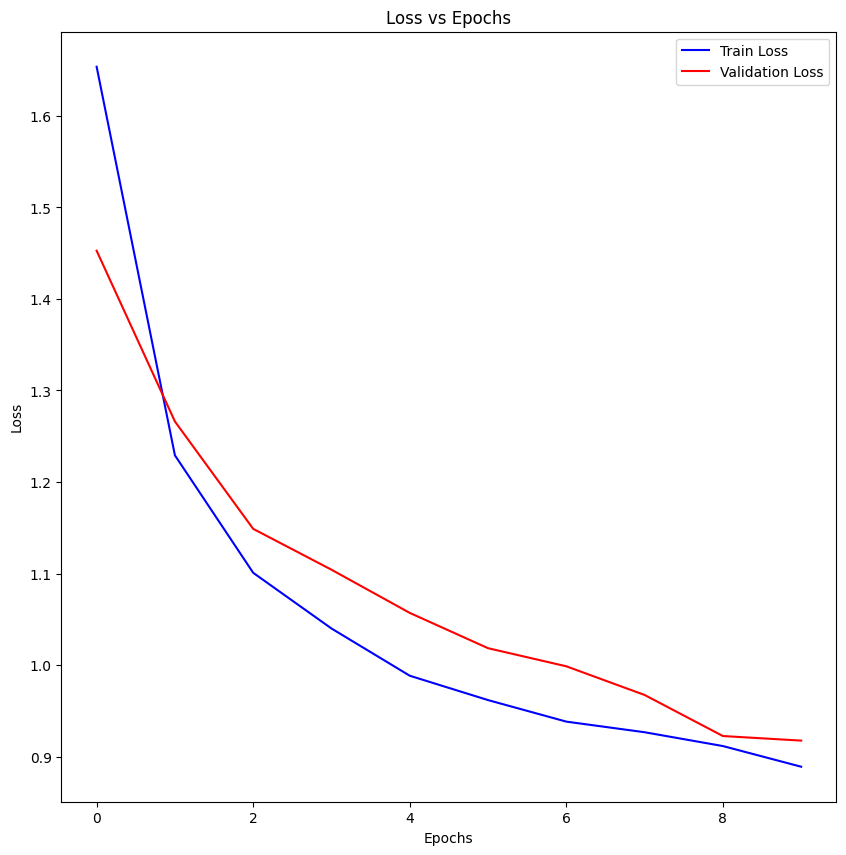

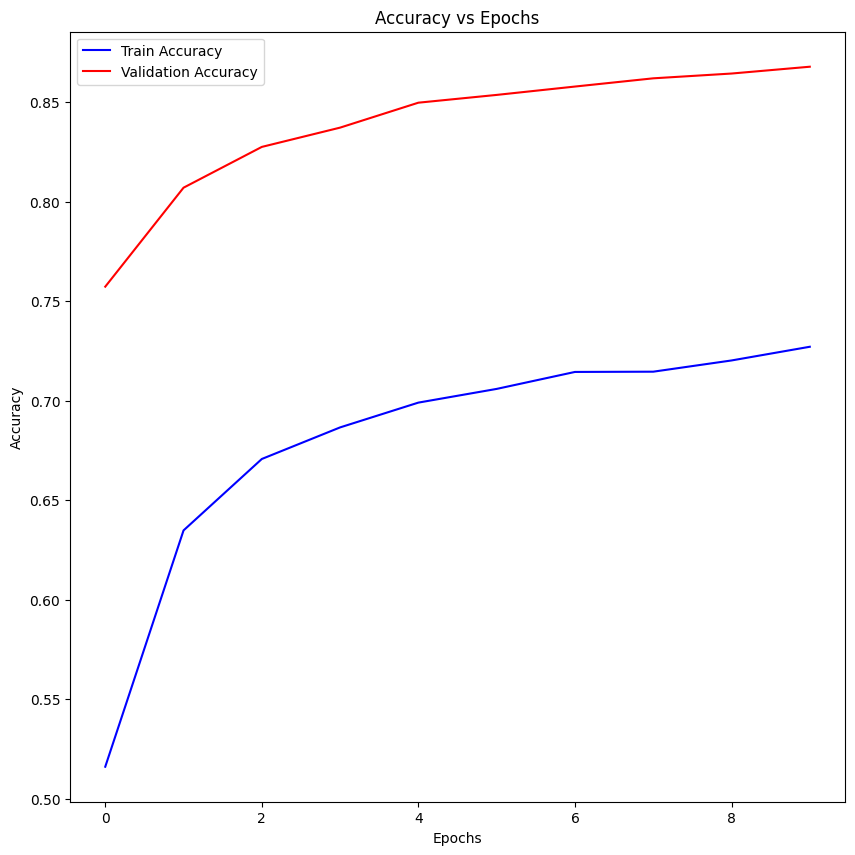

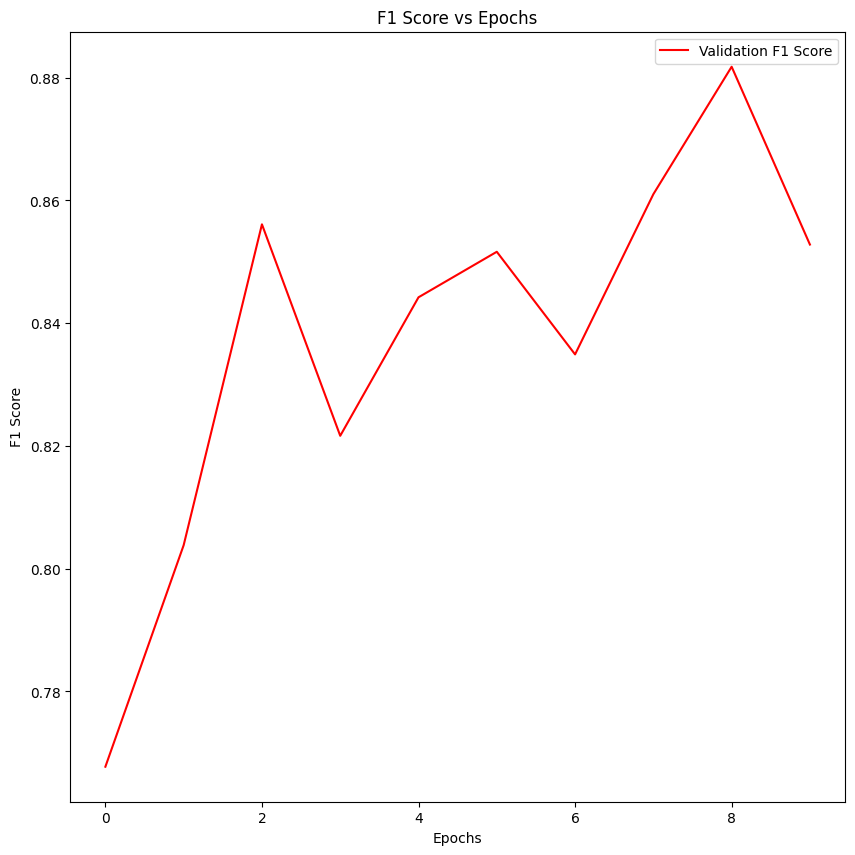

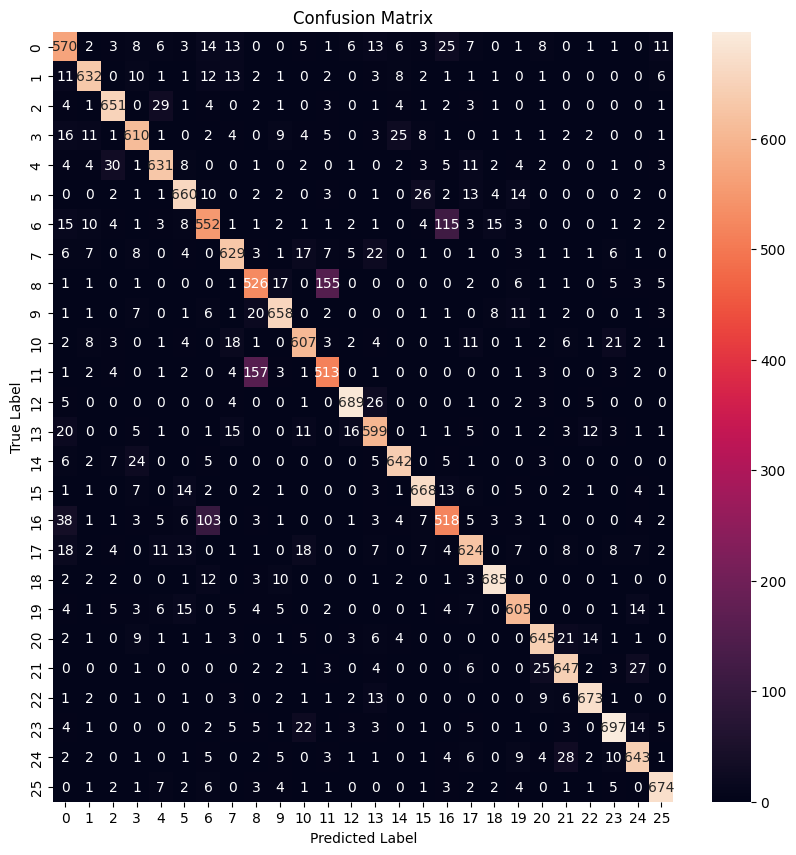

Learning Rate: 0.001


 10%|█         | 1/10 [01:12<10:51, 72.37s/it]

Epoch: 1
Training Loss: 2.2798
Validation Loss: 2.2521
Training Accuracy: 0.3723
Validation Accuracy: 0.6390
Validation F1 Score: 0.6640


 20%|██        | 2/10 [02:26<09:45, 73.22s/it]

Epoch: 2
Training Loss: 1.5927
Validation Loss: 2.0777
Training Accuracy: 0.5413
Validation Accuracy: 0.6988
Validation F1 Score: 0.7447


 30%|███       | 3/10 [03:36<08:24, 72.07s/it]

Epoch: 3
Training Loss: 1.4044
Validation Loss: 1.9041
Training Accuracy: 0.5960
Validation Accuracy: 0.7351
Validation F1 Score: 0.7980


 40%|████      | 4/10 [04:47<07:09, 71.51s/it]

Epoch: 4
Training Loss: 1.2921
Validation Loss: 1.7586
Training Accuracy: 0.6291
Validation Accuracy: 0.7559
Validation F1 Score: 0.7491


 50%|█████     | 5/10 [05:46<05:35, 67.10s/it]

Epoch: 5
Training Loss: 1.2153
Validation Loss: 1.6603
Training Accuracy: 0.6485
Validation Accuracy: 0.7759
Validation F1 Score: 0.7747


 60%|██████    | 6/10 [06:52<04:26, 66.70s/it]

Epoch: 6
Training Loss: 1.1648
Validation Loss: 1.5563
Training Accuracy: 0.6636
Validation Accuracy: 0.7890
Validation F1 Score: 0.7713


 70%|███████   | 7/10 [08:00<03:21, 67.08s/it]

Epoch: 7
Training Loss: 1.1168
Validation Loss: 1.4979
Training Accuracy: 0.6794
Validation Accuracy: 0.8020
Validation F1 Score: 0.7610


 80%|████████  | 8/10 [09:08<02:14, 67.22s/it]

Epoch: 8
Training Loss: 1.0835
Validation Loss: 1.4418
Training Accuracy: 0.6846
Validation Accuracy: 0.8066
Validation F1 Score: 0.7745


 90%|█████████ | 9/10 [10:16<01:07, 67.67s/it]

Epoch: 9
Training Loss: 1.0593
Validation Loss: 1.3480
Training Accuracy: 0.6925
Validation Accuracy: 0.8212
Validation F1 Score: 0.8399


100%|██████████| 10/10 [11:24<00:00, 68.41s/it]

Epoch: 10
Training Loss: 1.0331
Validation Loss: 1.3255
Training Accuracy: 0.6982
Validation Accuracy: 0.8246
Validation F1 Score: 0.8245


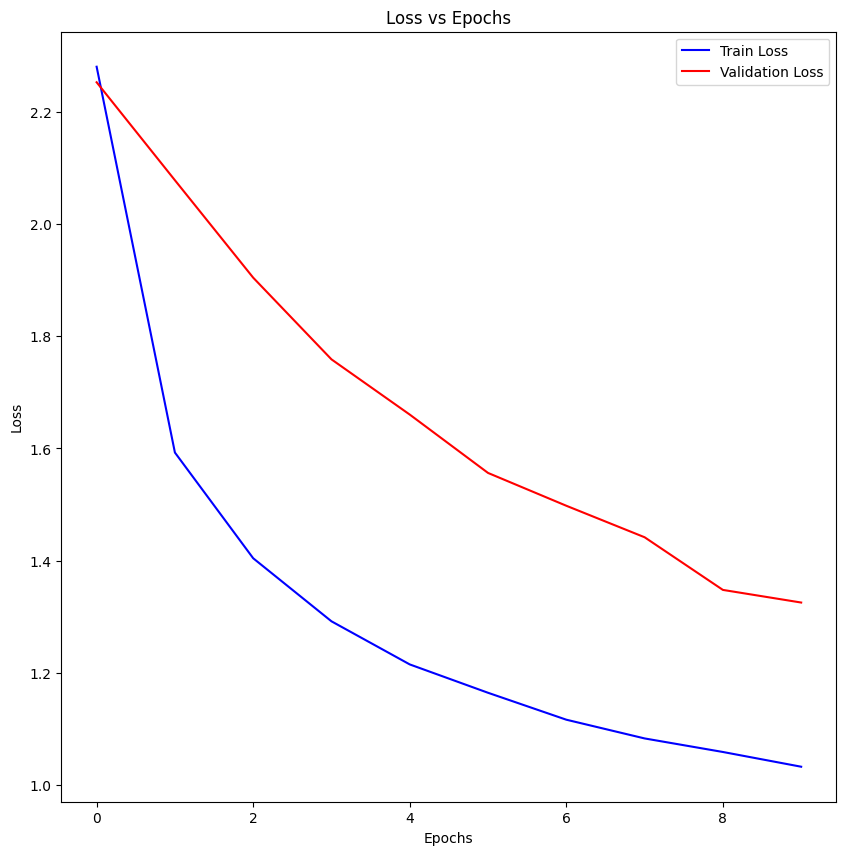

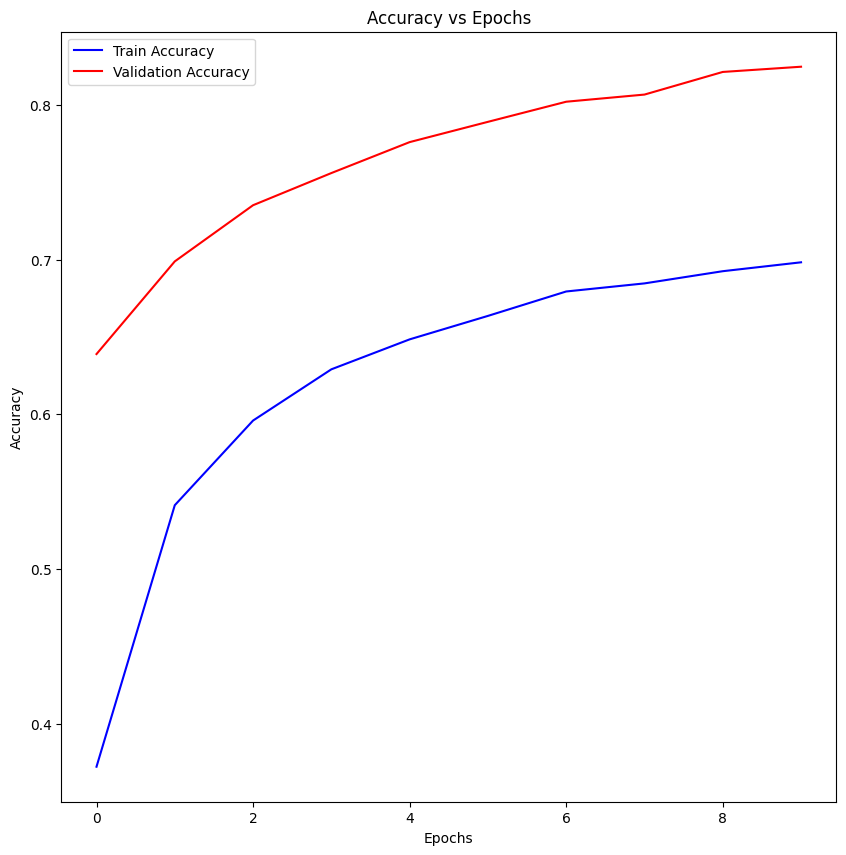

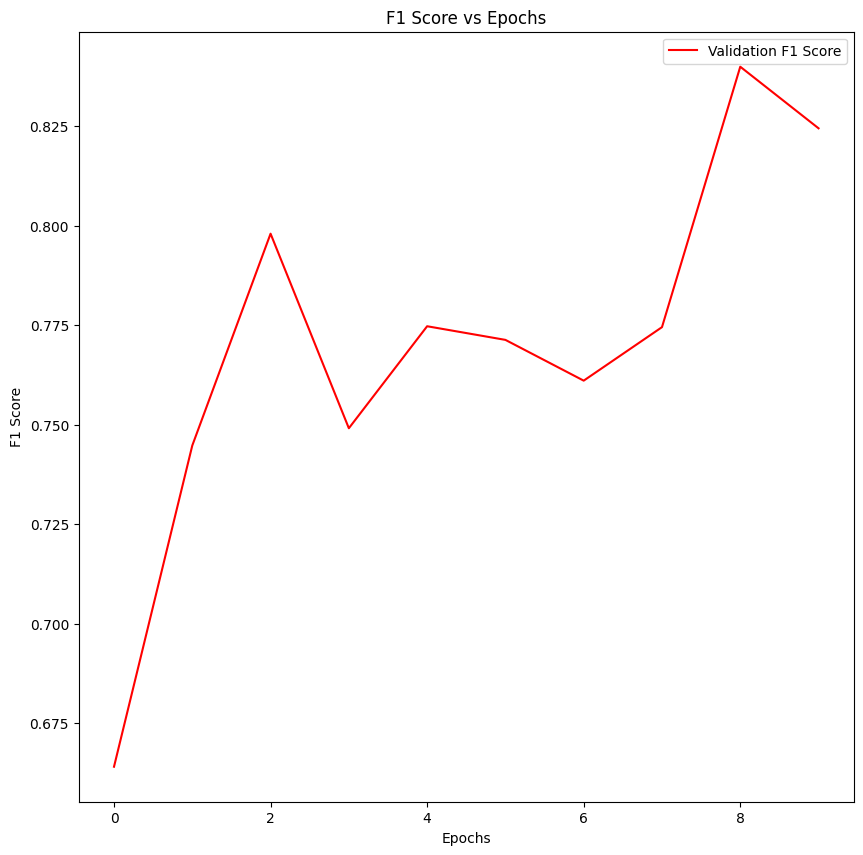

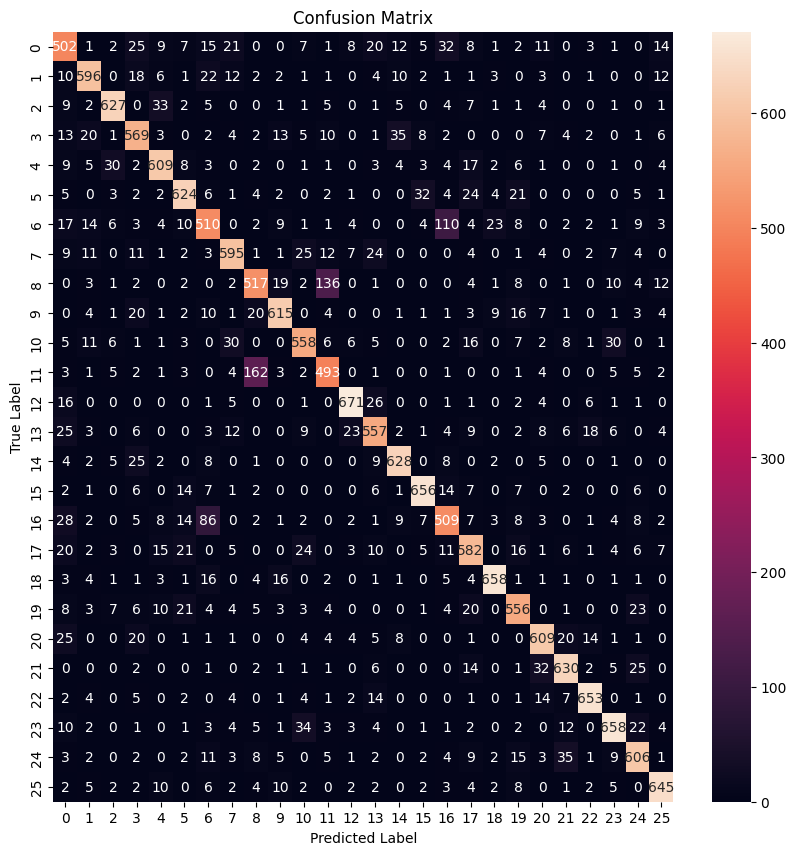

Learning Rate: 0.0005


 10%|█         | 1/10 [01:07<10:11, 67.99s/it]

Epoch: 1
Training Loss: 2.6505
Validation Loss: 1.9533
Training Accuracy: 0.2927
Validation Accuracy: 0.6026
Validation F1 Score: 0.5664


 20%|██        | 2/10 [02:14<08:57, 67.22s/it]

Epoch: 2
Training Loss: 1.8905
Validation Loss: 2.1482
Training Accuracy: 0.4729
Validation Accuracy: 0.6497
Validation F1 Score: 0.6365


 30%|███       | 3/10 [03:20<07:47, 66.72s/it]

Epoch: 3
Training Loss: 1.6513
Validation Loss: 2.1359
Training Accuracy: 0.5287
Validation Accuracy: 0.6812
Validation F1 Score: 0.6997


 40%|████      | 4/10 [04:30<06:47, 67.89s/it]

Epoch: 4
Training Loss: 1.5216
Validation Loss: 2.0768
Training Accuracy: 0.5635
Validation Accuracy: 0.7029
Validation F1 Score: 0.6947


 50%|█████     | 5/10 [05:39<05:40, 68.19s/it]

Epoch: 5
Training Loss: 1.4378
Validation Loss: 1.9694
Training Accuracy: 0.5881
Validation Accuracy: 0.7239
Validation F1 Score: 0.7563


 60%|██████    | 6/10 [06:47<04:33, 68.33s/it]

Epoch: 6
Training Loss: 1.3667
Validation Loss: 1.9274
Training Accuracy: 0.6072
Validation Accuracy: 0.7370
Validation F1 Score: 0.7063


 70%|███████   | 7/10 [07:54<03:23, 67.84s/it]

Epoch: 7
Training Loss: 1.3165
Validation Loss: 1.8270
Training Accuracy: 0.6241
Validation Accuracy: 0.7509
Validation F1 Score: 0.7527


 80%|████████  | 8/10 [09:02<02:15, 67.98s/it]

Epoch: 8
Training Loss: 1.2688
Validation Loss: 1.7709
Training Accuracy: 0.6349
Validation Accuracy: 0.7620
Validation F1 Score: 0.7564


 90%|█████████ | 9/10 [10:09<01:07, 67.52s/it]

Epoch: 9
Training Loss: 1.2317
Validation Loss: 1.7002
Training Accuracy: 0.6476
Validation Accuracy: 0.7706
Validation F1 Score: 0.7923


100%|██████████| 10/10 [11:16<00:00, 67.66s/it]

Epoch: 10
Training Loss: 1.1970
Validation Loss: 1.6585
Training Accuracy: 0.6565
Validation Accuracy: 0.7785
Validation F1 Score: 0.7712


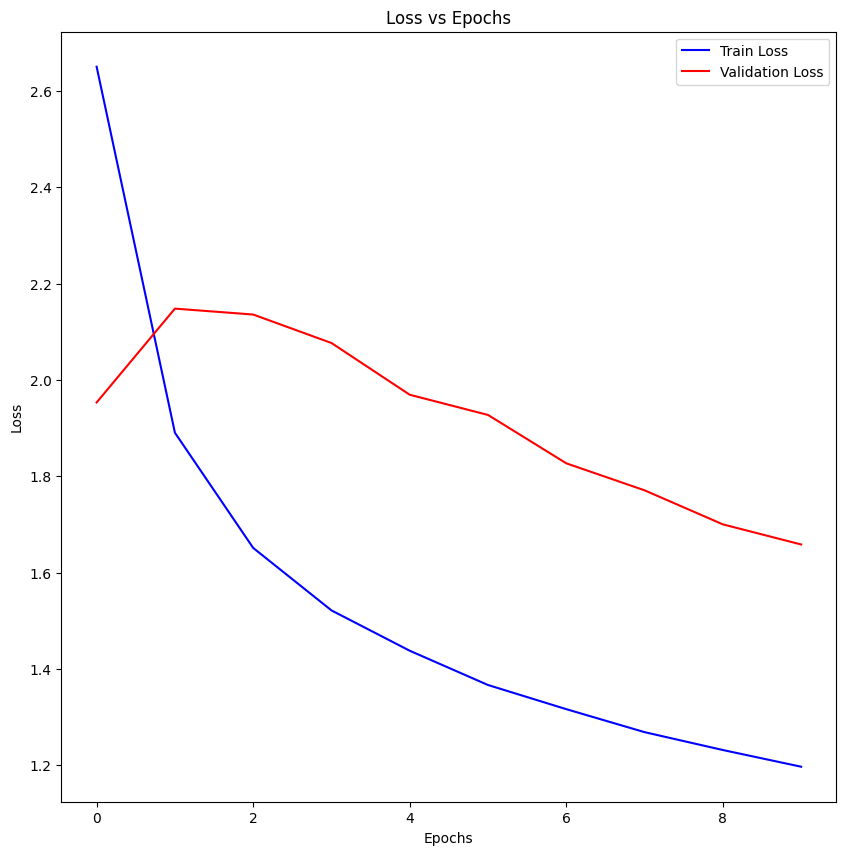

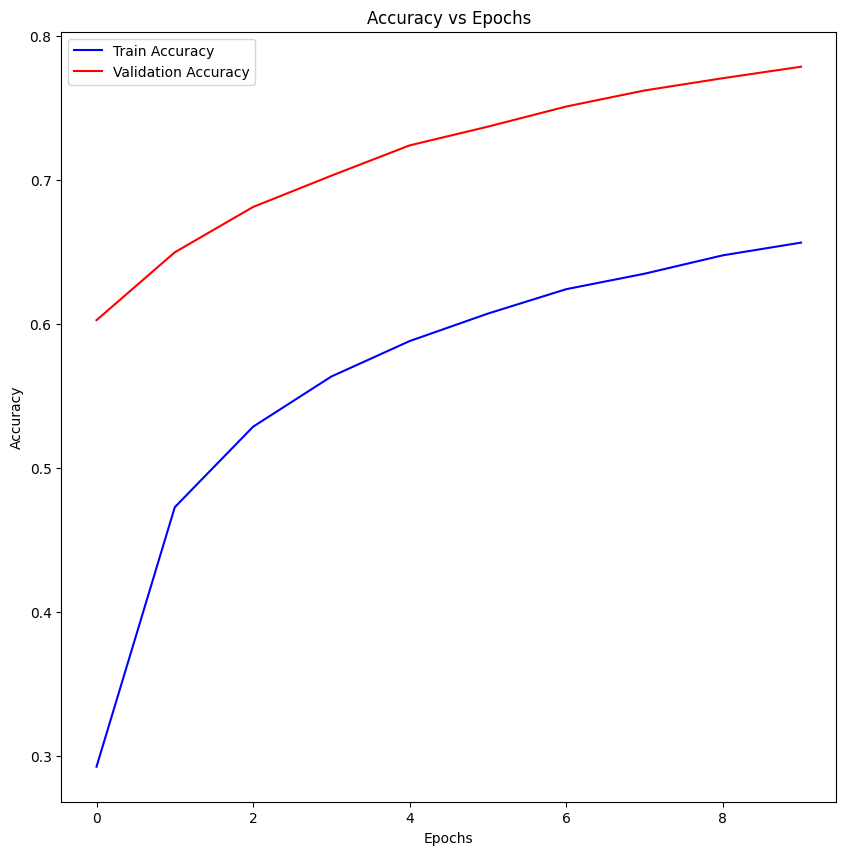

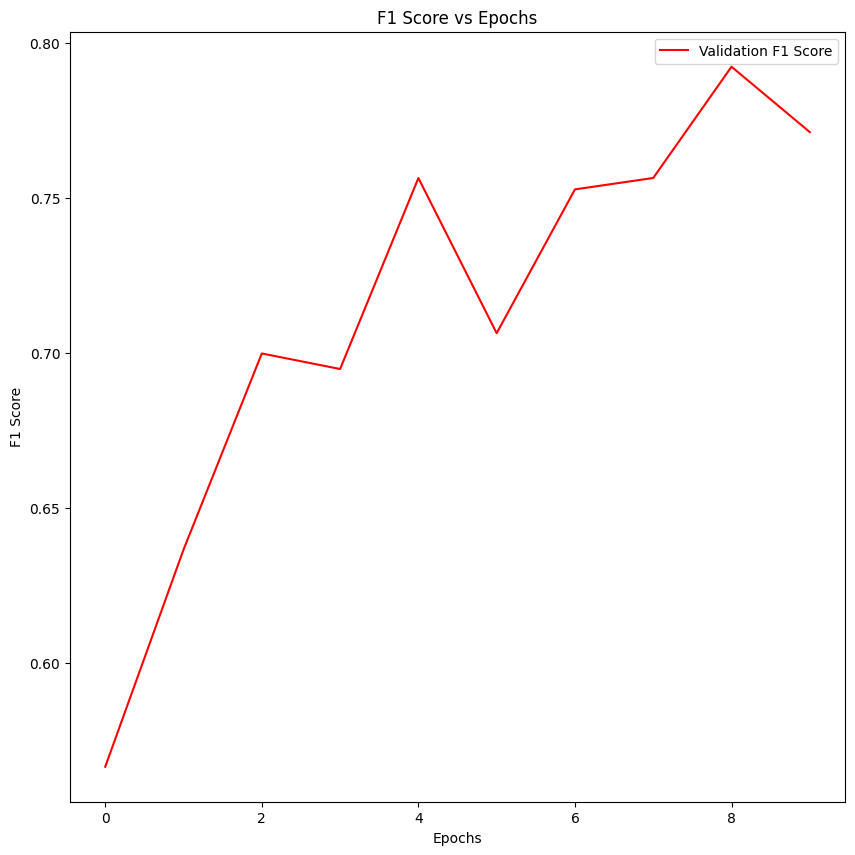

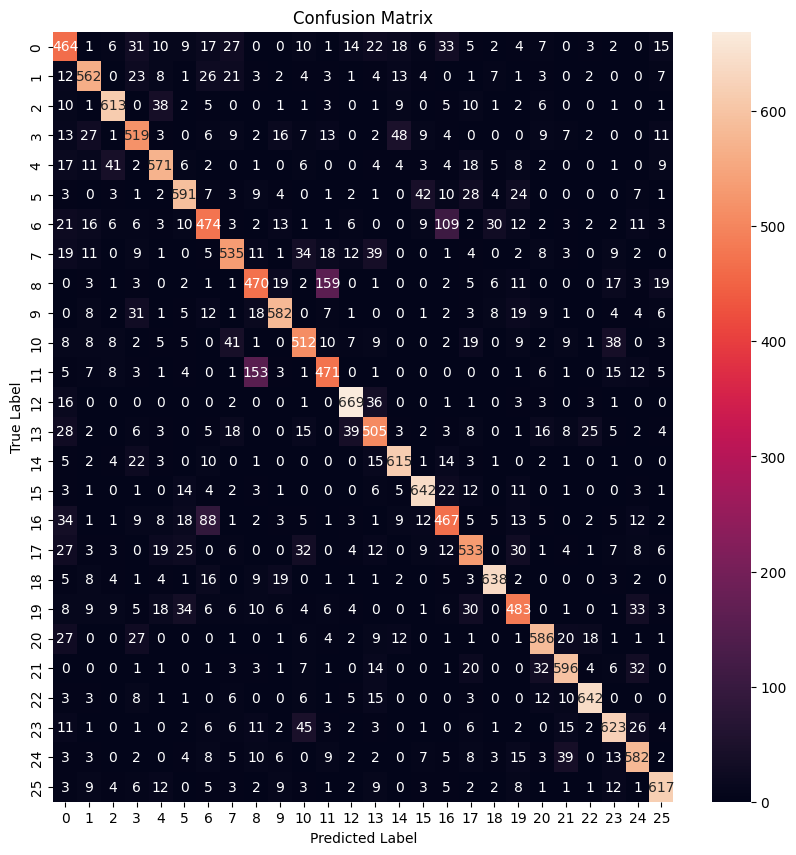

Learning Rate: 0.0001


 10%|█         | 1/10 [01:07<10:06, 67.35s/it]

Epoch: 1
Training Loss: 3.1454
Validation Loss: 1.9072
Training Accuracy: 0.1296
Validation Accuracy: 0.5086
Validation F1 Score: 0.5231


 20%|██        | 2/10 [02:15<09:04, 68.07s/it]

Epoch: 2
Training Loss: 2.8004
Validation Loss: 1.4770
Training Accuracy: 0.3003
Validation Accuracy: 0.5745
Validation F1 Score: 0.6113


 30%|███       | 3/10 [03:25<08:00, 68.58s/it]

Epoch: 3
Training Loss: 2.5086
Validation Loss: 1.5456
Training Accuracy: 0.3625
Validation Accuracy: 0.5979
Validation F1 Score: 0.5997


 40%|████      | 4/10 [04:25<06:31, 65.24s/it]

Epoch: 4
Training Loss: 2.2906
Validation Loss: 1.6739
Training Accuracy: 0.4033
Validation Accuracy: 0.6114
Validation F1 Score: 0.6440


 50%|█████     | 5/10 [05:09<04:48, 57.73s/it]

Epoch: 5
Training Loss: 2.1318
Validation Loss: 1.7775
Training Accuracy: 0.4331
Validation Accuracy: 0.6209
Validation F1 Score: 0.6236


 60%|██████    | 6/10 [05:53<03:31, 52.91s/it]

Epoch: 6
Training Loss: 2.0145
Validation Loss: 1.8746
Training Accuracy: 0.4535
Validation Accuracy: 0.6286
Validation F1 Score: 0.5895


 70%|███████   | 7/10 [06:36<02:29, 49.79s/it]

Epoch: 7
Training Loss: 1.9255
Validation Loss: 1.9381
Training Accuracy: 0.4696
Validation Accuracy: 0.6370
Validation F1 Score: 0.6064


 80%|████████  | 8/10 [07:20<01:35, 47.87s/it]

Epoch: 8
Training Loss: 1.8518
Validation Loss: 1.9667
Training Accuracy: 0.4857
Validation Accuracy: 0.6480
Validation F1 Score: 0.6609


 90%|█████████ | 9/10 [08:05<00:46, 46.89s/it]

Epoch: 9
Training Loss: 1.7949
Validation Loss: 2.0140
Training Accuracy: 0.4972
Validation Accuracy: 0.6532
Validation F1 Score: 0.6372


100%|██████████| 10/10 [09:08<00:00, 54.83s/it]

Epoch: 10
Training Loss: 1.7430
Validation Loss: 2.0190
Training Accuracy: 0.5109
Validation Accuracy: 0.6615
Validation F1 Score: 0.6515


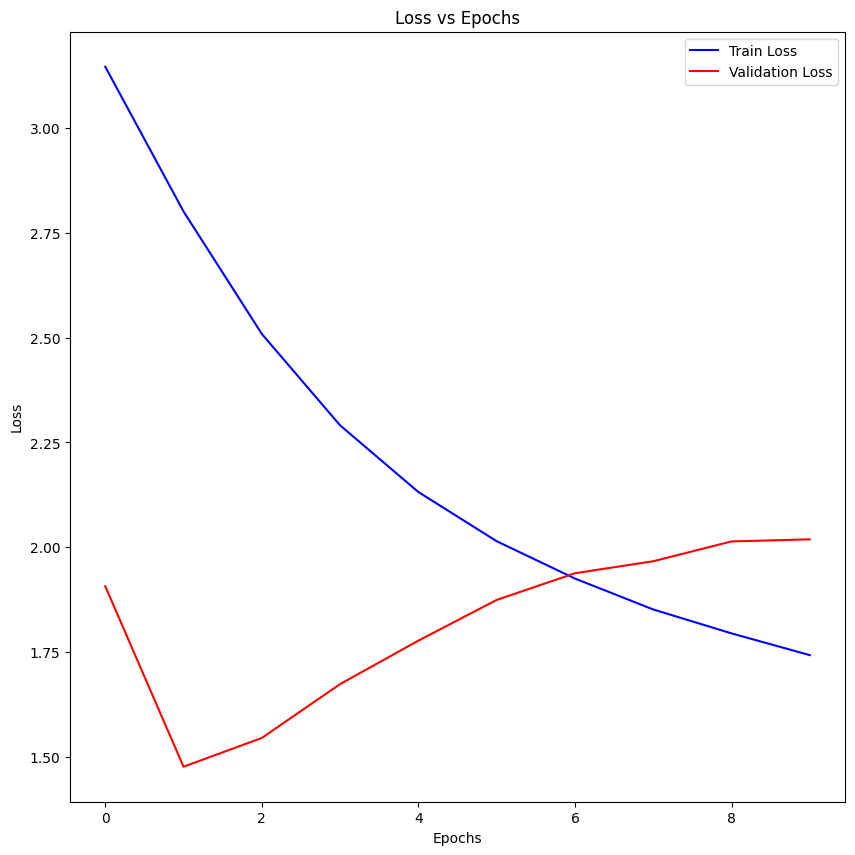

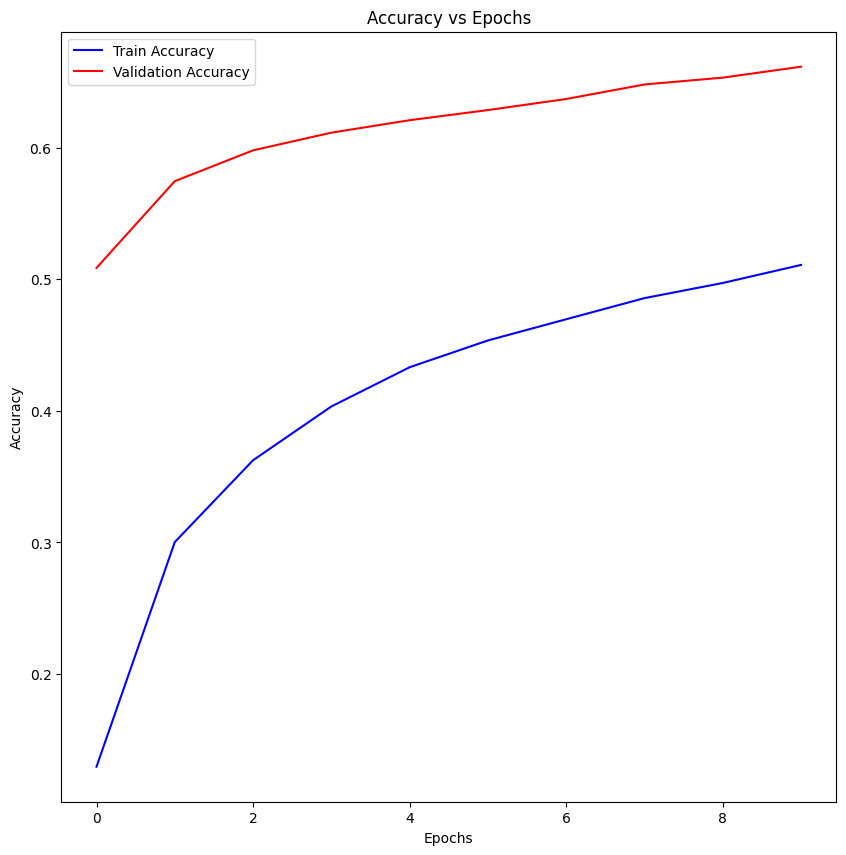

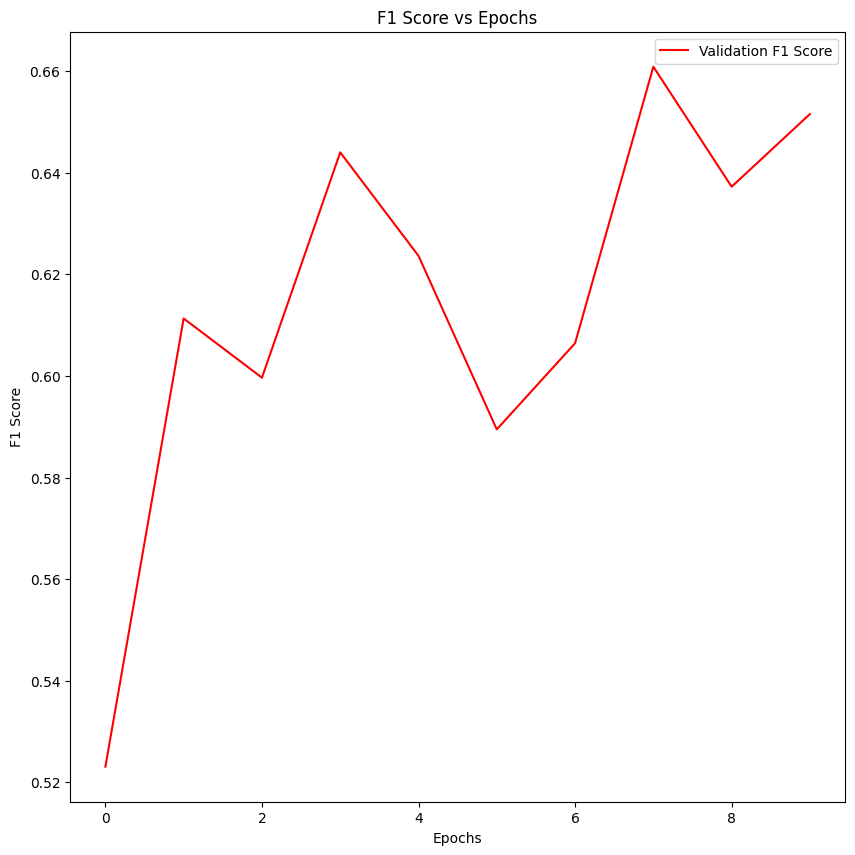

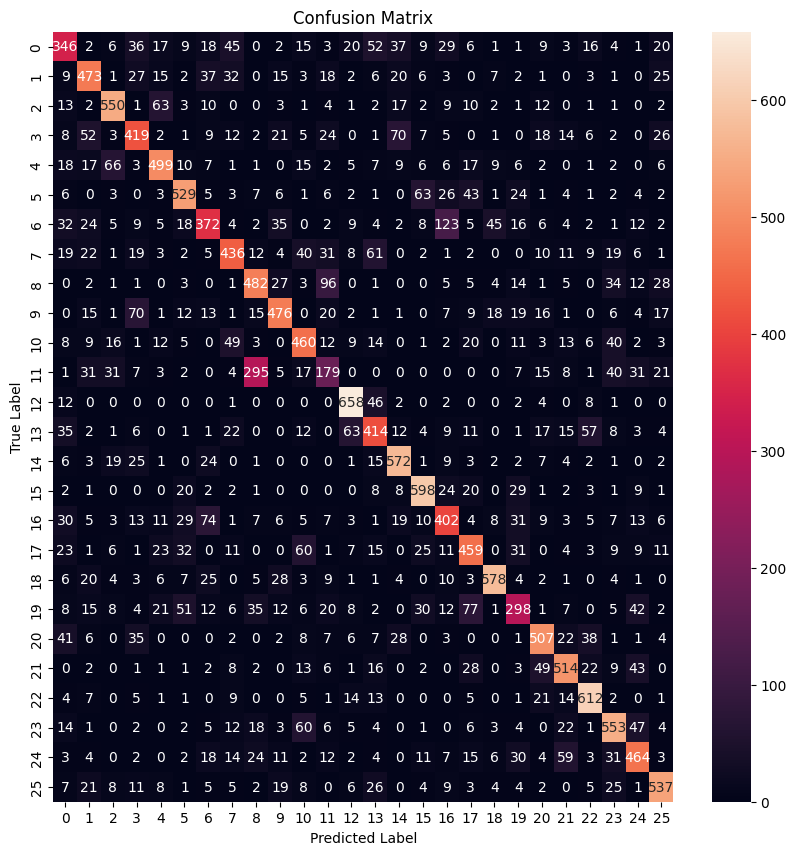

Best Learning Rate: 0.005
Best Validation Mark: 0.8678214089912281
Best Parameters: [array([[ 0.0380997 , -0.01657849, -0.01054542, ...,  0.00120626,
        -0.08560696, -0.03131482],
       [ 0.04311354,  0.03331068, -0.04057836, ..., -0.06320205,
        -0.03643631, -0.03779216],
       [ 0.02234573, -0.04668749,  0.06868474, ...,  0.03952963,
        -0.00870841, -0.02788744],
       ...,
       [ 0.03313479, -0.06542028, -0.03730955, ..., -0.02621713,
         0.02529123, -0.02319707],
       [-0.00308576, -0.01138026, -0.03530298, ..., -0.00733506,
         0.01991971, -0.0513925 ],
       [-0.04032297,  0.02451688,  0.01034008, ..., -0.02084889,
         0.04113018,  0.00637908]]), array([[-0.28755741],
       [ 0.04789972],
       [-0.03671562],
       [-0.46620287],
       [-0.69152924],
       [ 0.23189281],
       [-0.28515516],
       [ 0.43219224],
       [-0.0314668 ],
       [ 0.41254977],
       [-0.42057997],
       [ 0.3360259 ],
       [-0.44891563],
       [ 0.3105

In [18]:
network2 = [
    DenseLayer(784, 512),
    ReLULayer(),
    dropout(0.15),
    DenseLayer(512, 26),
    SoftmaxLayer()
]

train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
validation_loader2 = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, shuffle=True)

test_loader2 = torch.utils.data.DataLoader(independent_test_dataset, batch_size=1024, shuffle=True)

learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]

best_validation_mark2 = 0
best_learning_rate2 = 0
best_parameters2 = None

for learning_rate in learning_rates:
    print("Learning Rate: {}".format(learning_rate))
    print("====================================")
    # Create the FNN model
    fnn_model = FNNModel(network2)
    
    train_loss_list = []
    validation_loss_list = []
    train_accuracy_list = []
    validation_accuracy_list = []
    validation_f1_list = []
    
    
    
    epochs = 10
    print_cost = True
    loss_type = 'multiclass'
    optimizer = "adam"
    
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        train_accuracy = 0
        validation_loss = 0
        validation_accuracy = 0
        
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy().T
            y = one_hot_encode(y.numpy(), 26)
            
            # Train the FNN model
            input = X
            output = y
            
            for layer in fnn_model.layers:
                layer.forward(input)
                input = layer.A
            
            #compute loss
            AL = fnn_model.layers[-1].A
            cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
            train_loss += cost
            
            #compute accuracy
            predictions = np.argmax(AL, axis=0)
            labels = np.argmax(output, axis=0)
            accuracy = np.mean(predictions == labels)
            train_accuracy += accuracy
            
            #backward propagation
            fnn_model.backward_propagation(X, y, AL, loss_type=loss_type)
            fnn_model.update_parameters(learning_rate, optimizer=optimizer)
            
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        
        validation_y_true_list = []
        validation_y_pred_list = []
        
        
        for X, y in validation_loader:
            X = X.view(X.shape[0], -1).numpy().T
            y = one_hot_encode(y.numpy(), 26)
            
            # Train the FNN model
            input = X
            output = y
            
            for layer in fnn_model.layers:
                #if dropout layer, skip
                if isinstance(layer, dropout):
                    continue
                layer.forward(input)
                input = layer.A
            
            #compute loss
            AL = fnn_model.layers[-1].A
            cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
            validation_loss += cost
            
            #compute accuracy
            predictions = np.argmax(AL, axis=0)
            labels = np.argmax(output, axis=0)
            accuracy = np.mean(predictions == labels)
            validation_accuracy += accuracy
            
            #populate the lists for confusion matrix
            validation_y_true_list.extend(labels)
            validation_y_pred_list.extend(predictions)
            
            # #backward propagation
            # fnn_model.compute_last_layer_dAL(AL, output, loss_type=loss_type)
            # dAL = fnn_model.dAL
            # for layer in reversed(fnn_model.layers):
            #     #if dropout layer, skip
            #     if isinstance(layer, dropout):
            #         continue
            #     dAL = layer.backward(dAL)
            # fnn_model.update_parameters(learning_rate, optimizer=optimizer)
            
        
        validation_y_true_list = np.array(validation_y_true_list)
        validation_y_pred_list = np.array(validation_y_pred_list)
        
        validation_loss /= len(validation_loader)
        validation_accuracy /= len(validation_loader)
        validation_f1_score = f1_score(labels, predictions, average='macro')
        
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_f1_list.append(validation_f1_score)
        
        print("Epoch: {}".format(epoch+1))
        print("Training Loss: {:.4f}".format(train_loss))
        print("Validation Loss: {:.4f}".format(validation_loss))
        print("Training Accuracy: {:.4f}".format(train_accuracy))
        print("Validation Accuracy: {:.4f}".format(validation_accuracy))
        print("Validation F1 Score: {:.4f}".format(validation_f1_score))
        print("====================================")
        
        if validation_accuracy > best_validation_mark2:
            best_validation_mark2 = validation_accuracy
            best_learning_rate2 = learning_rate
            best_parameters2 = fnn_model.parameters
            
    
        
        
        
    #plot the loss and accuracy curves

    plt.figure(figsize=(10, 10))
    plt.plot(train_loss_list, label="Train Loss", color="blue")
    plt.plot(validation_loss_list, label="Validation Loss", color="red")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(f"plots/2_loss_{learning_rate}.png")
    plt.legend()

    plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy_list, label="Train Accuracy", color="blue")
    plt.plot(validation_accuracy_list, label="Validation Accuracy", color="red")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig(f"plots/2_accuracy_{learning_rate}.png")
    plt.legend()     

    plt.figure(figsize=(10, 10))
    plt.plot(validation_f1_list, label="Validation F1 Score", color="red")
    plt.title("F1 Score vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.savefig(f"plots/2_f1_score_{learning_rate}.png")
    plt.legend()
    
    
    #confusion matrix
    cm = confusion_matrix(validation_y_true_list, validation_y_pred_list)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(f"plots/2_confusion_matrix_{learning_rate}.png")
    plt.show()
    
    

print("Best Learning Rate: {}".format(best_learning_rate2))
print("Best Validation Mark: {}".format(best_validation_mark2))
print("Best Parameters: {}".format(best_parameters2))
 
        

Learning Rate: 0.005


 10%|█         | 1/10 [01:00<09:04, 60.54s/it]

Epoch: 1
Training Loss: 1.4354
Validation Loss: 1.3860
Training Accuracy: 0.5786
Validation Accuracy: 0.7824
Validation F1 Score: 0.7667


 20%|██        | 2/10 [02:18<09:24, 70.60s/it]

Epoch: 2
Training Loss: 0.9938
Validation Loss: 1.1442
Training Accuracy: 0.7051
Validation Accuracy: 0.8306
Validation F1 Score: 0.8125


 30%|███       | 3/10 [03:37<08:41, 74.51s/it]

Epoch: 3
Training Loss: 0.8679
Validation Loss: 1.0432
Training Accuracy: 0.7360
Validation Accuracy: 0.8518
Validation F1 Score: 0.8438


 40%|████      | 4/10 [04:57<07:40, 76.76s/it]

Epoch: 4
Training Loss: 0.8007
Validation Loss: 0.9412
Training Accuracy: 0.7545
Validation Accuracy: 0.8696
Validation F1 Score: 0.8928


 50%|█████     | 5/10 [06:19<06:32, 78.45s/it]

Epoch: 5
Training Loss: 0.7580
Validation Loss: 0.8934
Training Accuracy: 0.7690
Validation Accuracy: 0.8740
Validation F1 Score: 0.8738


 60%|██████    | 6/10 [07:37<05:14, 78.56s/it]

Epoch: 6
Training Loss: 0.7366
Validation Loss: 0.8292
Training Accuracy: 0.7734
Validation Accuracy: 0.8844
Validation F1 Score: 0.9137


 70%|███████   | 7/10 [08:58<03:57, 79.19s/it]

Epoch: 7
Training Loss: 0.7062
Validation Loss: 0.8057
Training Accuracy: 0.7813
Validation Accuracy: 0.8896
Validation F1 Score: 0.9021


 80%|████████  | 8/10 [10:18<02:39, 79.51s/it]

Epoch: 8
Training Loss: 0.6960
Validation Loss: 0.7696
Training Accuracy: 0.7835
Validation Accuracy: 0.8932
Validation F1 Score: 0.9245


 90%|█████████ | 9/10 [11:40<01:20, 80.33s/it]

Epoch: 9
Training Loss: 0.6801
Validation Loss: 0.7671
Training Accuracy: 0.7892
Validation Accuracy: 0.8949
Validation F1 Score: 0.8852


100%|██████████| 10/10 [13:01<00:00, 78.18s/it]

Epoch: 10
Training Loss: 0.6679
Validation Loss: 0.7249
Training Accuracy: 0.7917
Validation Accuracy: 0.8979
Validation F1 Score: 0.8932


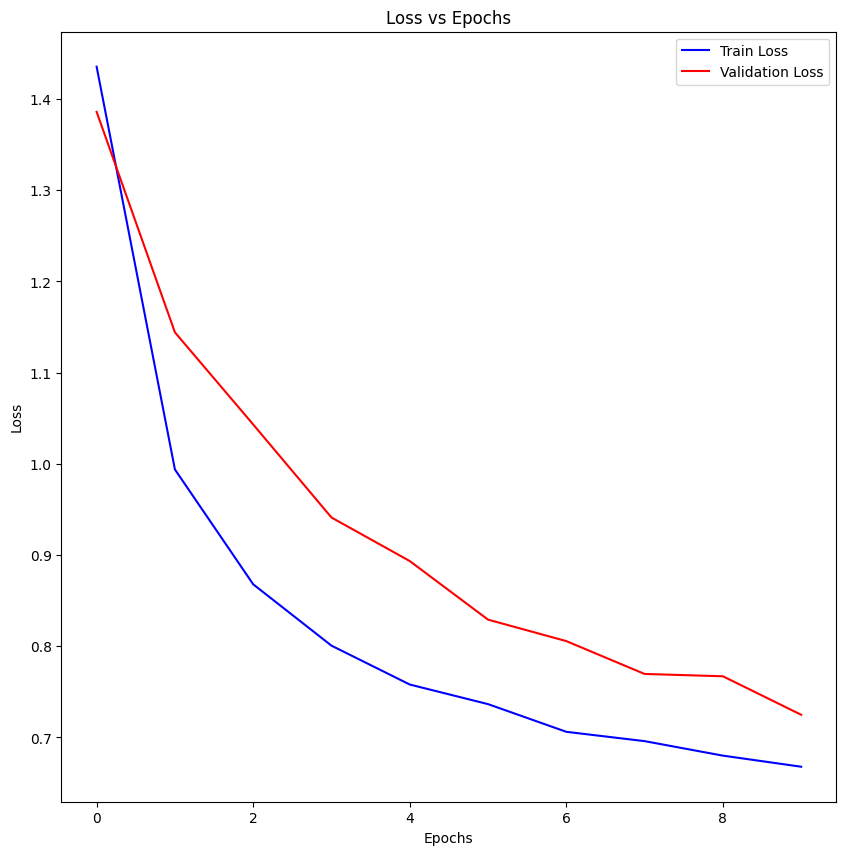

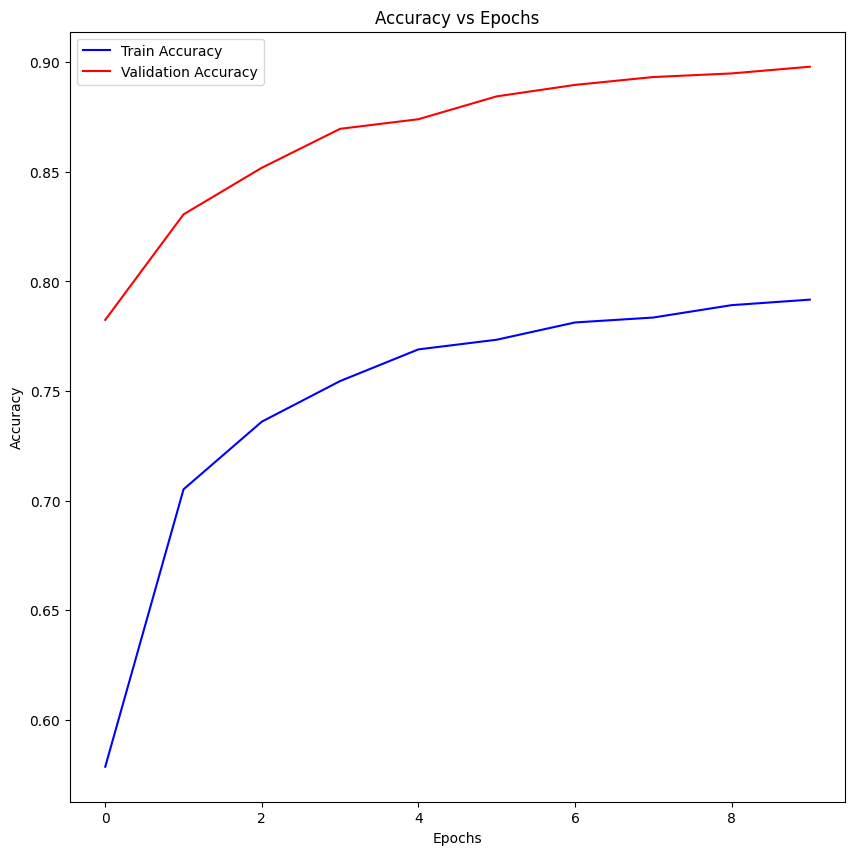

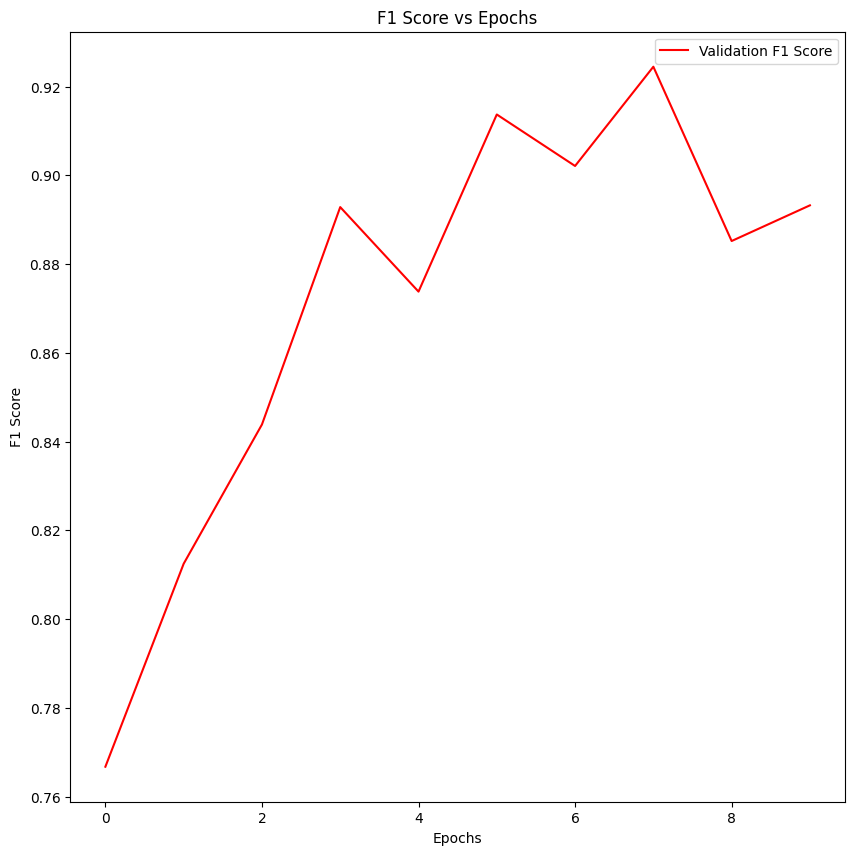

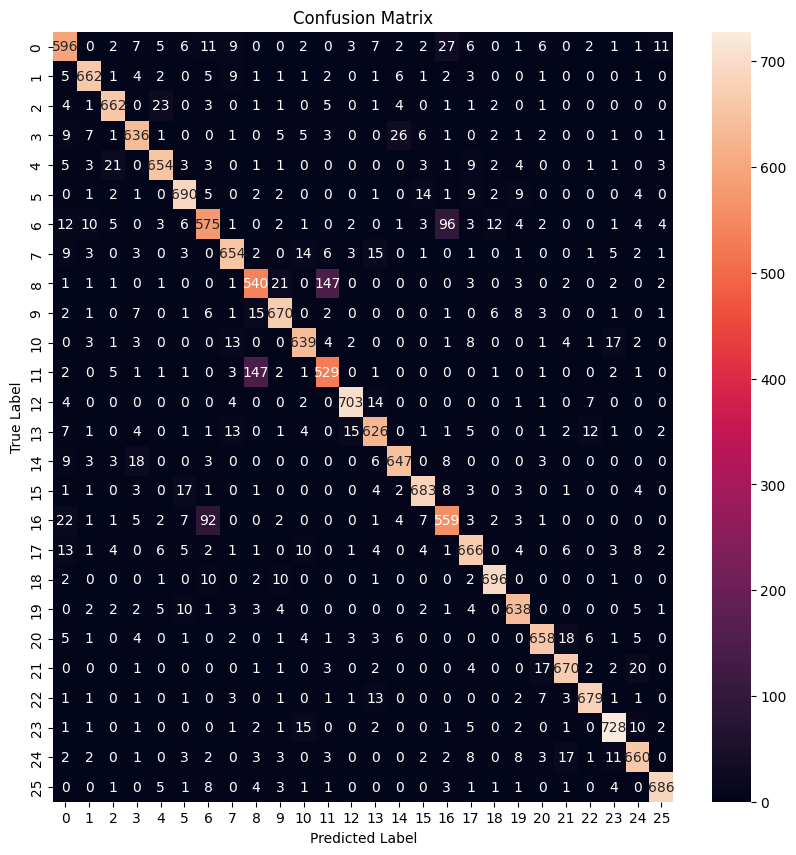

Learning Rate: 0.001


 10%|█         | 1/10 [01:19<11:55, 79.49s/it]

Epoch: 1
Training Loss: 2.0157
Validation Loss: 2.3934
Training Accuracy: 0.4501
Validation Accuracy: 0.6639
Validation F1 Score: 0.6808


 20%|██        | 2/10 [02:38<10:32, 79.04s/it]

Epoch: 2
Training Loss: 1.3579
Validation Loss: 2.0270
Training Accuracy: 0.6129
Validation Accuracy: 0.7306
Validation F1 Score: 0.7363


 30%|███       | 3/10 [03:58<09:16, 79.50s/it]

Epoch: 3
Training Loss: 1.1808
Validation Loss: 1.7817
Training Accuracy: 0.6634
Validation Accuracy: 0.7687
Validation F1 Score: 0.7971


 40%|████      | 4/10 [05:22<08:08, 81.47s/it]

Epoch: 4
Training Loss: 1.0681
Validation Loss: 1.5946
Training Accuracy: 0.6974
Validation Accuracy: 0.7915
Validation F1 Score: 0.7916


 50%|█████     | 5/10 [06:40<06:41, 80.22s/it]

Epoch: 5
Training Loss: 0.9890
Validation Loss: 1.4441
Training Accuracy: 0.7172
Validation Accuracy: 0.8137
Validation F1 Score: 0.8629


 60%|██████    | 6/10 [07:42<04:55, 73.96s/it]

Epoch: 6
Training Loss: 0.9261
Validation Loss: 1.3407
Training Accuracy: 0.7351
Validation Accuracy: 0.8277
Validation F1 Score: 0.8113


 70%|███████   | 7/10 [08:39<03:25, 68.38s/it]

Epoch: 7
Training Loss: 0.8788
Validation Loss: 1.2733
Training Accuracy: 0.7463
Validation Accuracy: 0.8347
Validation F1 Score: 0.8233


 80%|████████  | 8/10 [09:34<02:08, 64.24s/it]

Epoch: 8
Training Loss: 0.8486
Validation Loss: 1.1996
Training Accuracy: 0.7535
Validation Accuracy: 0.8432
Validation F1 Score: 0.8244


 90%|█████████ | 9/10 [10:29<01:01, 61.40s/it]

Epoch: 9
Training Loss: 0.8209
Validation Loss: 1.1576
Training Accuracy: 0.7612
Validation Accuracy: 0.8490
Validation F1 Score: 0.8356


100%|██████████| 10/10 [11:25<00:00, 68.53s/it]

Epoch: 10
Training Loss: 0.7949
Validation Loss: 1.1159
Training Accuracy: 0.7685
Validation Accuracy: 0.8558
Validation F1 Score: 0.8529


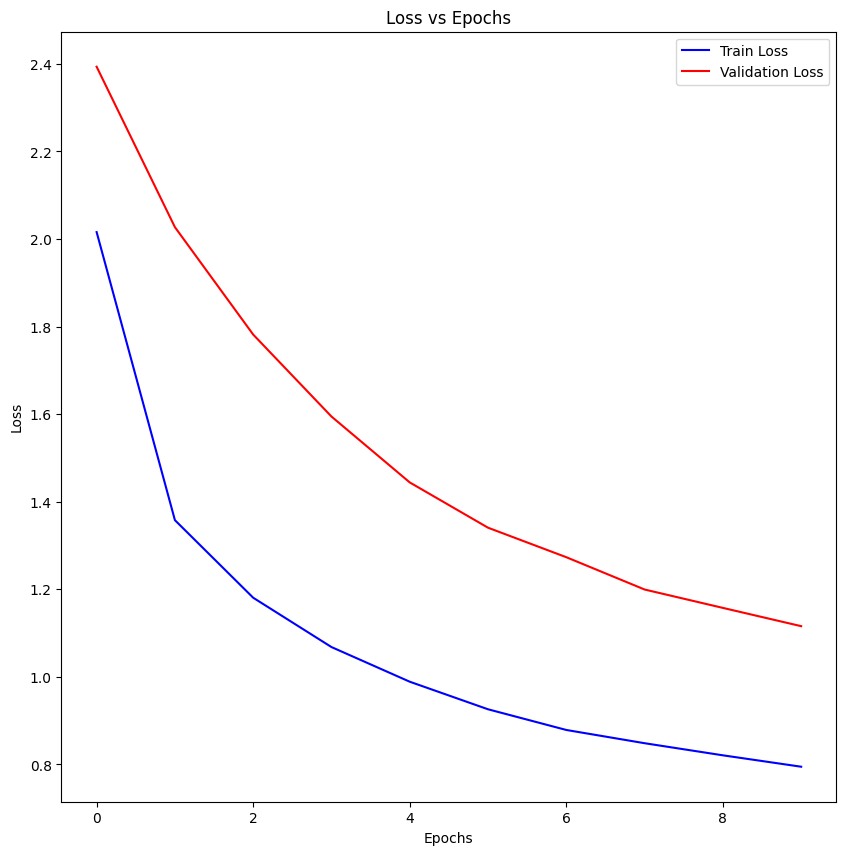

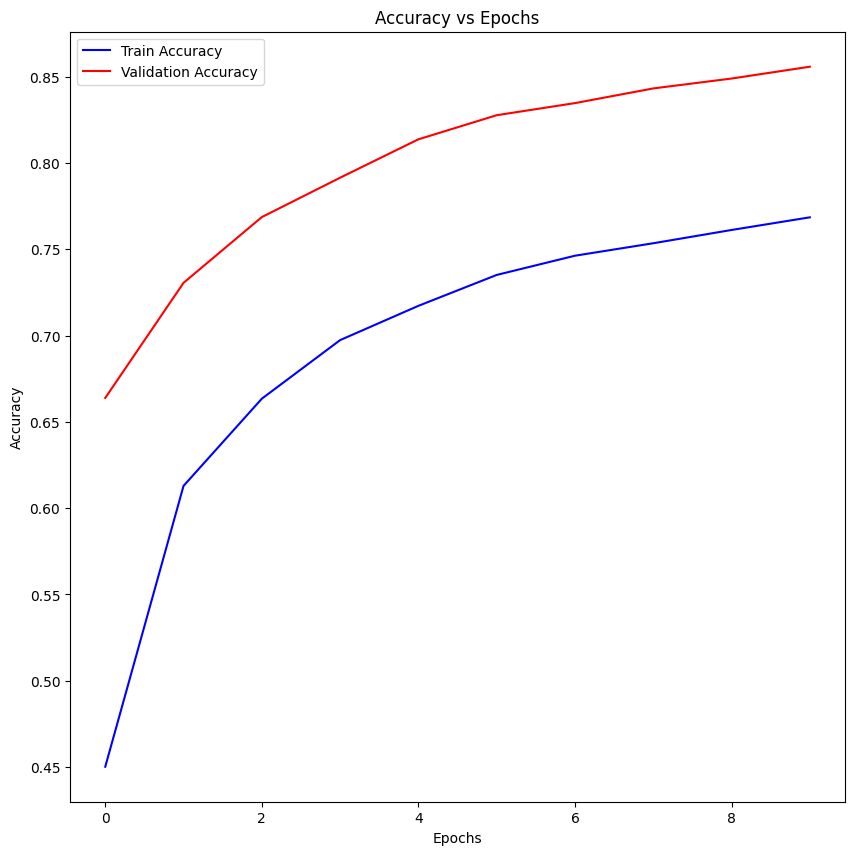

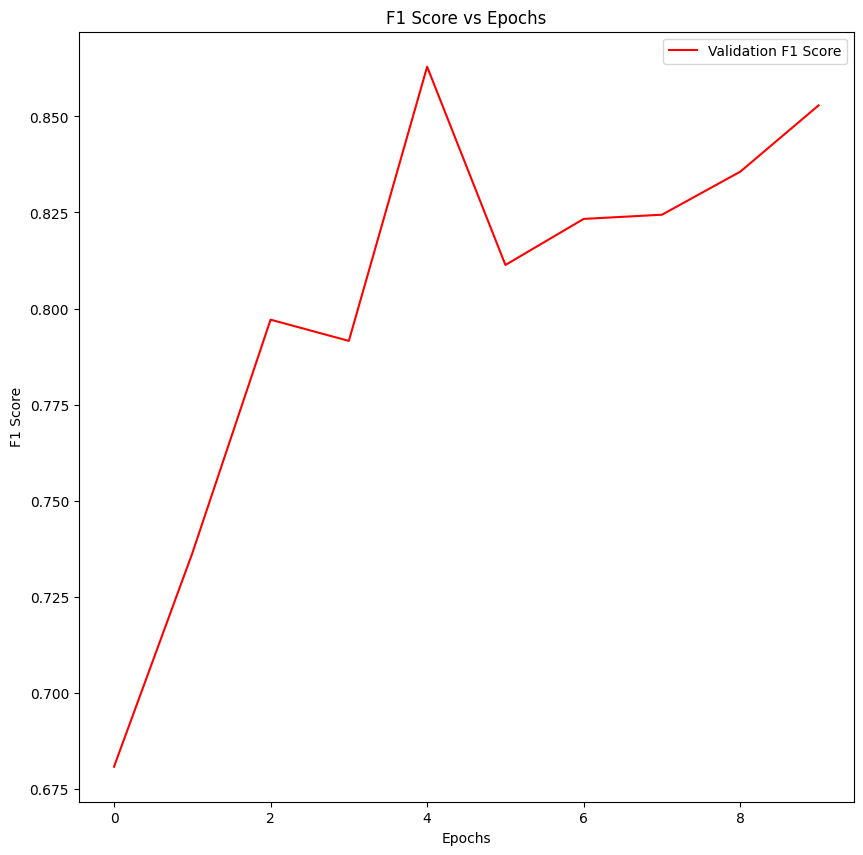

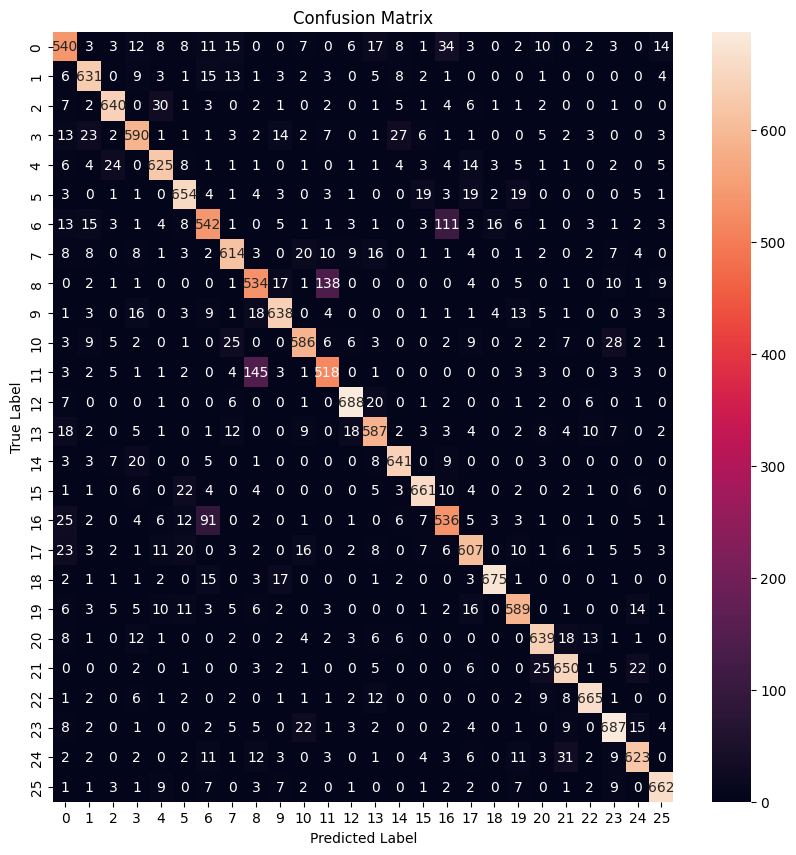

Learning Rate: 0.0005


 10%|█         | 1/10 [00:55<08:20, 55.58s/it]

Epoch: 1
Training Loss: 2.3957
Validation Loss: 2.3291
Training Accuracy: 0.3786
Validation Accuracy: 0.6225
Validation F1 Score: 0.6868


 20%|██        | 2/10 [01:52<07:30, 56.31s/it]

Epoch: 2
Training Loss: 1.6009
Validation Loss: 2.3849
Training Accuracy: 0.5537
Validation Accuracy: 0.6732
Validation F1 Score: 0.6830


 30%|███       | 3/10 [02:47<06:30, 55.83s/it]

Epoch: 3
Training Loss: 1.3990
Validation Loss: 2.2212
Training Accuracy: 0.6048
Validation Accuracy: 0.7087
Validation F1 Score: 0.7176


 40%|████      | 4/10 [03:42<05:33, 55.56s/it]

Epoch: 4
Training Loss: 1.2855
Validation Loss: 2.0668
Training Accuracy: 0.6356
Validation Accuracy: 0.7353
Validation F1 Score: 0.7656


 50%|█████     | 5/10 [04:38<04:37, 55.44s/it]

Epoch: 5
Training Loss: 1.1953
Validation Loss: 1.9082
Training Accuracy: 0.6624
Validation Accuracy: 0.7560
Validation F1 Score: 0.7961


 60%|██████    | 6/10 [05:33<03:41, 55.29s/it]

Epoch: 6
Training Loss: 1.1298
Validation Loss: 1.7982
Training Accuracy: 0.6823
Validation Accuracy: 0.7687
Validation F1 Score: 0.7400


 70%|███████   | 7/10 [06:28<02:46, 55.43s/it]

Epoch: 7
Training Loss: 1.0719
Validation Loss: 1.6844
Training Accuracy: 0.6979
Validation Accuracy: 0.7848
Validation F1 Score: 0.7611


 80%|████████  | 8/10 [07:24<01:50, 55.38s/it]

Epoch: 8
Training Loss: 1.0275
Validation Loss: 1.5858
Training Accuracy: 0.7098
Validation Accuracy: 0.7965
Validation F1 Score: 0.8290


 90%|█████████ | 9/10 [08:19<00:55, 55.53s/it]

Epoch: 9
Training Loss: 0.9896
Validation Loss: 1.4936
Training Accuracy: 0.7195
Validation Accuracy: 0.8099
Validation F1 Score: 0.8200


100%|██████████| 10/10 [09:15<00:00, 55.57s/it]

Epoch: 10
Training Loss: 0.9564
Validation Loss: 1.4318
Training Accuracy: 0.7280
Validation Accuracy: 0.8176
Validation F1 Score: 0.8297


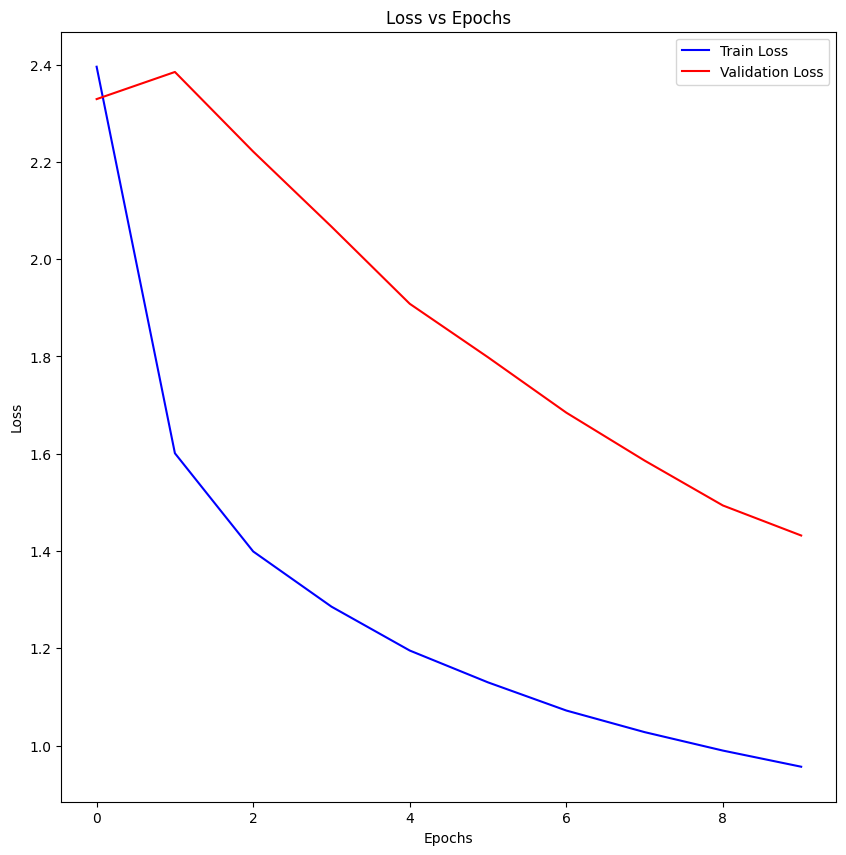

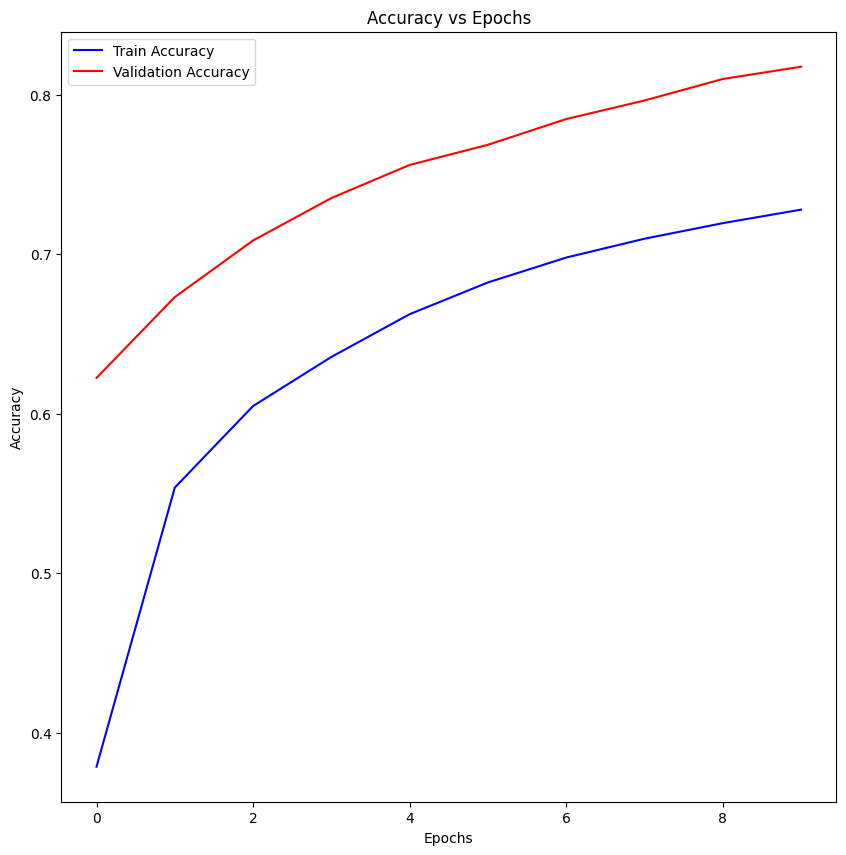

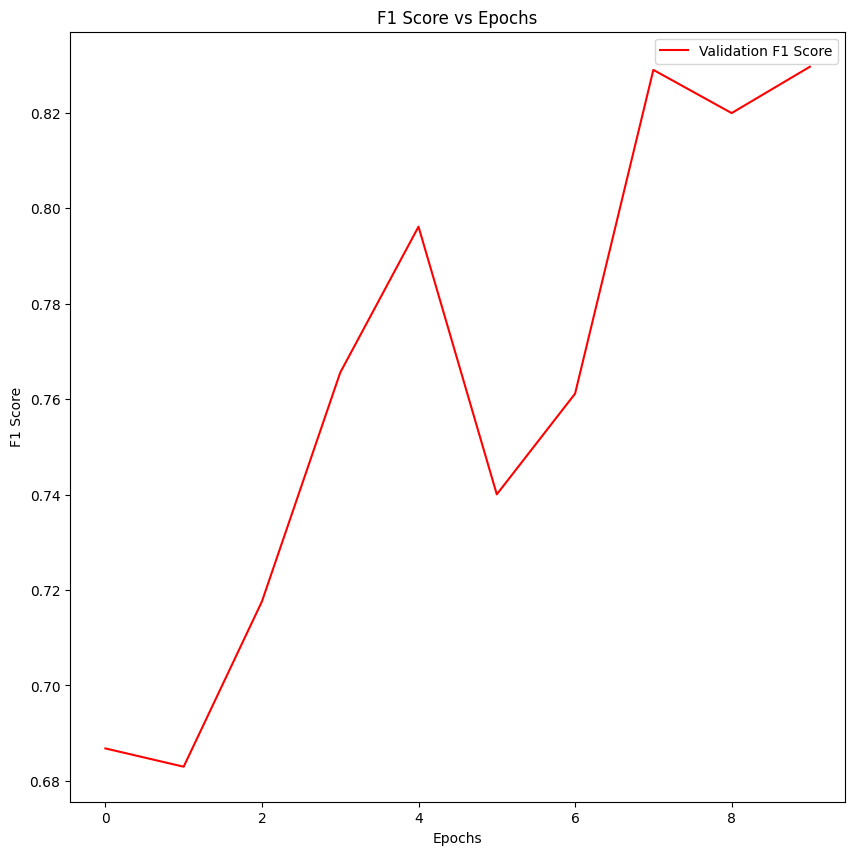

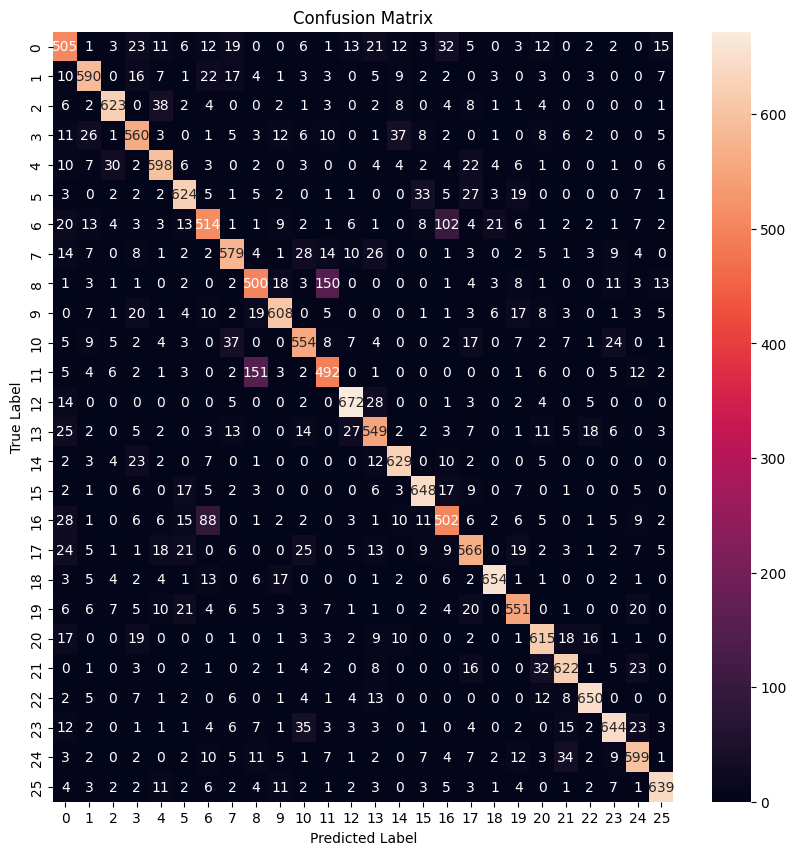

Learning Rate: 0.0001


 10%|█         | 1/10 [00:56<08:24, 56.09s/it]

Epoch: 1
Training Loss: 3.0806
Validation Loss: 1.6156
Training Accuracy: 0.1928
Validation Accuracy: 0.5446
Validation F1 Score: 0.5678


 20%|██        | 2/10 [01:52<07:28, 56.04s/it]

Epoch: 2
Training Loss: 2.5948
Validation Loss: 1.5500
Training Accuracy: 0.3976
Validation Accuracy: 0.5907
Validation F1 Score: 0.5935


 30%|███       | 3/10 [02:47<06:30, 55.76s/it]

Epoch: 3
Training Loss: 2.2218
Validation Loss: 1.7756
Training Accuracy: 0.4544
Validation Accuracy: 0.6104
Validation F1 Score: 0.5863


 40%|████      | 4/10 [03:43<05:36, 56.04s/it]

Epoch: 4
Training Loss: 1.9833
Validation Loss: 1.9484
Training Accuracy: 0.4893
Validation Accuracy: 0.6255
Validation F1 Score: 0.6403


 50%|█████     | 5/10 [04:39<04:39, 55.84s/it]

Epoch: 5
Training Loss: 1.8308
Validation Loss: 2.0764
Training Accuracy: 0.5149
Validation Accuracy: 0.6370
Validation F1 Score: 0.6480


 60%|██████    | 6/10 [05:34<03:42, 55.70s/it]

Epoch: 6
Training Loss: 1.7175
Validation Loss: 2.1496
Training Accuracy: 0.5367
Validation Accuracy: 0.6470
Validation F1 Score: 0.6173


 70%|███████   | 7/10 [06:29<02:46, 55.48s/it]

Epoch: 7
Training Loss: 1.6357
Validation Loss: 2.1988
Training Accuracy: 0.5522
Validation Accuracy: 0.6570
Validation F1 Score: 0.6479


 80%|████████  | 8/10 [07:30<01:54, 57.17s/it]

Epoch: 8
Training Loss: 1.5751
Validation Loss: 2.1966
Training Accuracy: 0.5648
Validation Accuracy: 0.6676
Validation F1 Score: 0.6346


 90%|█████████ | 9/10 [08:26<00:56, 56.89s/it]

Epoch: 9
Training Loss: 1.5278
Validation Loss: 2.2030
Training Accuracy: 0.5759
Validation Accuracy: 0.6752
Validation F1 Score: 0.6675


100%|██████████| 10/10 [09:22<00:00, 56.20s/it]

Epoch: 10
Training Loss: 1.4859
Validation Loss: 2.2011
Training Accuracy: 0.5849
Validation Accuracy: 0.6846
Validation F1 Score: 0.6719


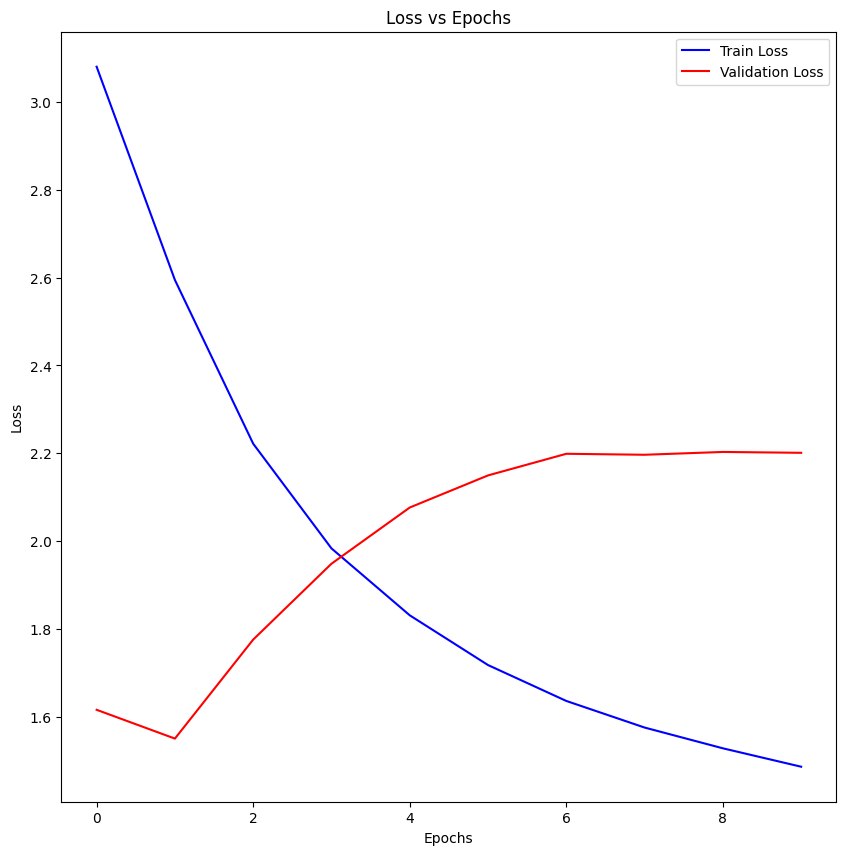

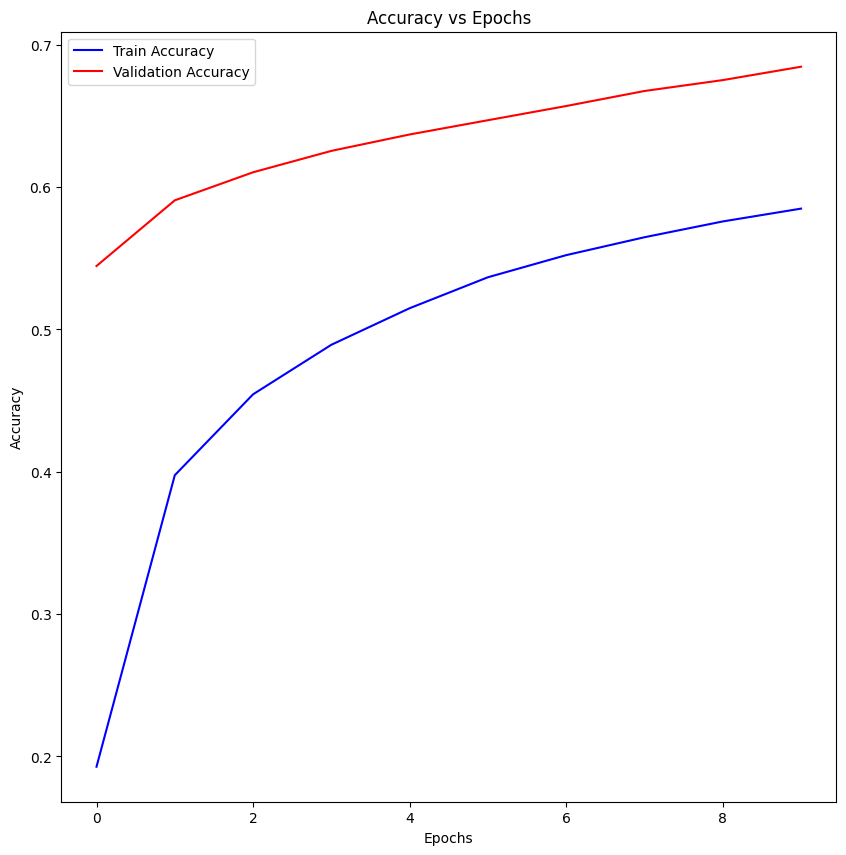

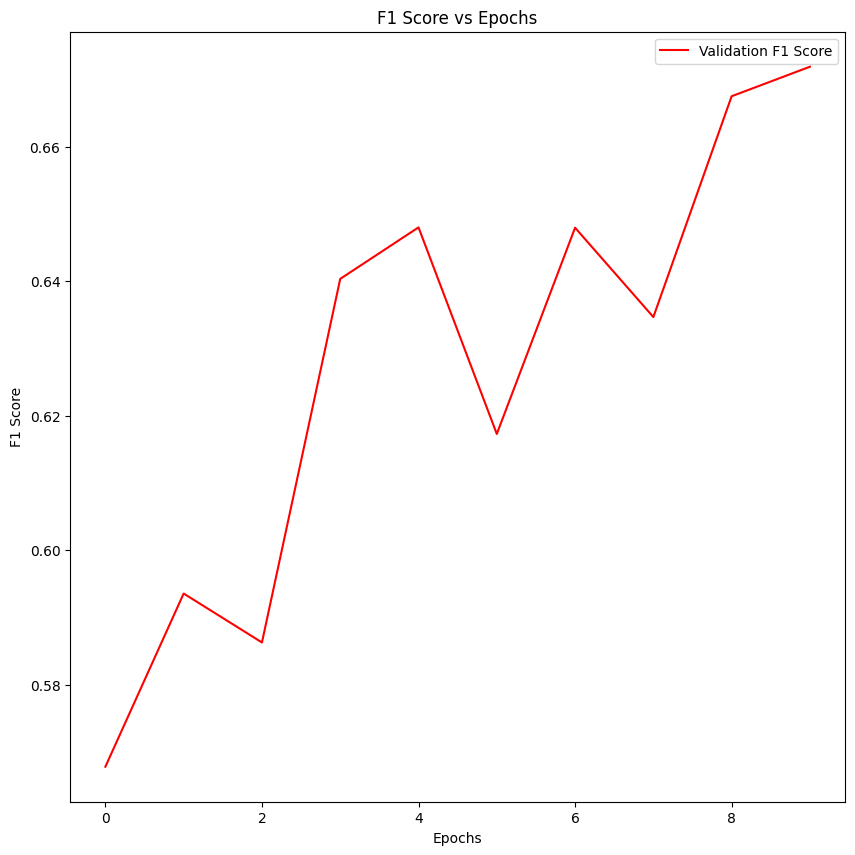

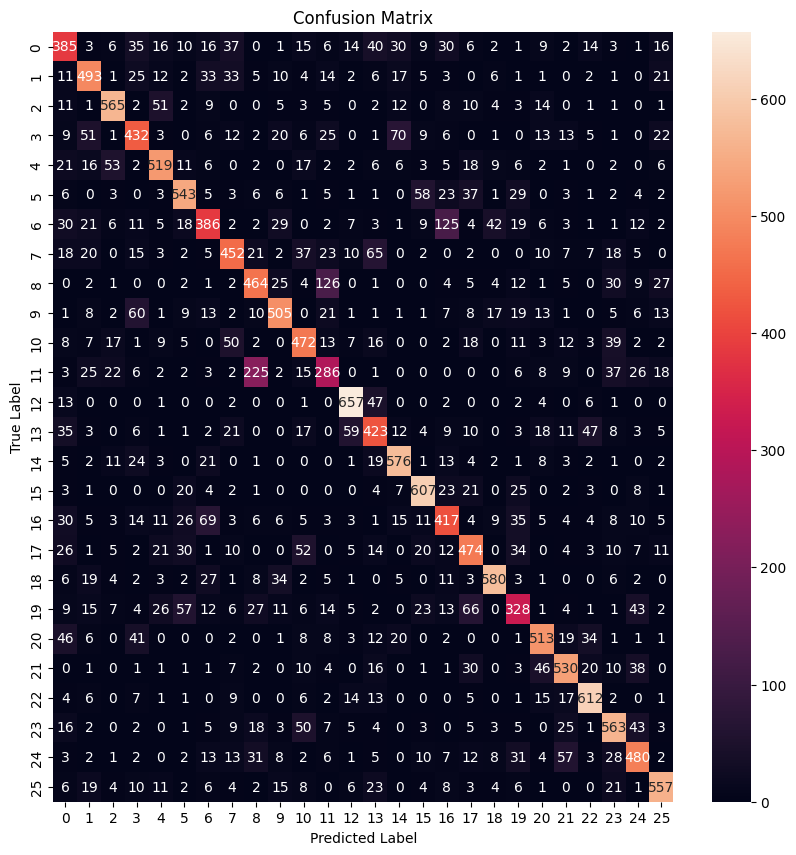

Best Learning Rate: 0.005
Best Validation Mark: 0.8979463633040936
Best Parameters: [array([[ 0.05132681,  0.00149451, -0.01128302, ...,  0.01041304,
        -0.03954136,  0.0031388 ],
       [-0.00558497, -0.03352325,  0.01910901, ..., -0.04947857,
         0.02431631, -0.03414189],
       [-0.02159025,  0.00913649, -0.0350196 , ..., -0.00511187,
        -0.03717642, -0.02090223],
       ...,
       [-0.03628327,  0.02486563,  0.01446467, ...,  0.04808017,
         0.03656171,  0.0289444 ],
       [ 0.04882034,  0.00496569, -0.00560756, ..., -0.07947259,
        -0.00128498,  0.03583211],
       [ 0.00070796,  0.03291957, -0.06176334, ...,  0.02541411,
        -0.01044205, -0.00667273]]), array([[ 0.42606395],
       [ 0.16256655],
       [-0.0344207 ],
       ...,
       [-0.0803821 ],
       [ 0.05086395],
       [-0.1678753 ]]), array([[-0.1059178 , -0.11025911,  0.02911839, ..., -0.37884069,
        -0.0020198 ,  0.10807437],
       [-0.22653143,  0.03720363,  0.04315528, ...,  0.

In [19]:
network3 = [
    DenseLayer(784, 1024),
    ReLULayer(),
    dropout(0.15),
    DenseLayer(1024, 26),
    SoftmaxLayer()
]

train_loader3 = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
validation_loader3 = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, shuffle=True)

test_loader3 = torch.utils.data.DataLoader(independent_test_dataset, batch_size=1024, shuffle=True)

learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]

best_validation_mark3 = 0
best_learning_rate3 = 0
best_parameters3 = None

for learning_rate in learning_rates:
    print("Learning Rate: {}".format(learning_rate))
    print("====================================")
    # Create the FNN model
    fnn_model = FNNModel(network3)
    
    train_loss_list = []
    validation_loss_list = []
    train_accuracy_list = []
    validation_accuracy_list = []
    validation_f1_list = []
    
    
    
    epochs = 10
    print_cost = True
    loss_type = 'multiclass'
    optimizer = "adam"
    
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        train_accuracy = 0
        validation_loss = 0
        validation_accuracy = 0
        
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy().T
            y = one_hot_encode(y.numpy(), 26)
            
            # Train the FNN model
            input = X
            output = y
            
            for layer in fnn_model.layers:
                layer.forward(input)
                input = layer.A
            
            #compute loss
            AL = fnn_model.layers[-1].A
            cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
            train_loss += cost
            
            #compute accuracy
            predictions = np.argmax(AL, axis=0)
            labels = np.argmax(output, axis=0)
            accuracy = np.mean(predictions == labels)
            train_accuracy += accuracy
            
            #backward propagation
            fnn_model.backward_propagation(X, y, AL, loss_type=loss_type)
            fnn_model.update_parameters(learning_rate, optimizer=optimizer)
            
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        
        validation_y_true_list = []
        validation_y_pred_list = []
        
        
        for X, y in validation_loader:
            X = X.view(X.shape[0], -1).numpy().T
            y = one_hot_encode(y.numpy(), 26)
            
            # Train the FNN model
            input = X
            output = y
            
            for layer in fnn_model.layers:
                #if dropout layer, skip
                if isinstance(layer, dropout):
                    continue
                layer.forward(input)
                input = layer.A
            
            #compute loss
            AL = fnn_model.layers[-1].A
            cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
            validation_loss += cost
            
            #compute accuracy
            predictions = np.argmax(AL, axis=0)
            labels = np.argmax(output, axis=0)
            accuracy = np.mean(predictions == labels)
            validation_accuracy += accuracy
            
            #populate the lists for confusion matrix
            validation_y_true_list.extend(labels)
            validation_y_pred_list.extend(predictions)
            
            #backward propagation
            fnn_model.compute_last_layer_dAL(AL, output, loss_type=loss_type)    
            dAL = fnn_model.dAL        
            for layer in reversed(fnn_model.layers):
                #if dropout layer, skip
                if isinstance(layer, dropout):
                    continue
                dAL = layer.backward(dAL)     
            fnn_model.update_parameters(learning_rate, optimizer=optimizer)
            
        
        validation_y_true_list = np.array(validation_y_true_list)
        validation_y_pred_list = np.array(validation_y_pred_list)
        
        validation_loss /= len(validation_loader)
        validation_accuracy /= len(validation_loader)
        validation_f1_score = f1_score(labels, predictions, average='macro')
        
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
        validation_f1_list.append(validation_f1_score)
        
        print("Epoch: {}".format(epoch+1))
        print("Training Loss: {:.4f}".format(train_loss))
        print("Validation Loss: {:.4f}".format(validation_loss))
        print("Training Accuracy: {:.4f}".format(train_accuracy))
        print("Validation Accuracy: {:.4f}".format(validation_accuracy))
        print("Validation F1 Score: {:.4f}".format(validation_f1_score))
        print("====================================")
        
        if validation_accuracy > best_validation_mark3:
            best_validation_mark3 = validation_accuracy
            best_learning_rate3 = learning_rate
            best_parameters3 = fnn_model.parameters
            
    
        
        
        
    #plot the loss and accuracy curves

    plt.figure(figsize=(10, 10))
    plt.plot(train_loss_list, label="Train Loss", color="blue")
    plt.plot(validation_loss_list, label="Validation Loss", color="red")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(f"plots/3_loss_{learning_rate}.png")
    plt.legend()

    plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy_list, label="Train Accuracy", color="blue")
    plt.plot(validation_accuracy_list, label="Validation Accuracy", color="red")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.savefig(f"plots/3_accuracy_{learning_rate}.png")
    plt.legend()     

    plt.figure(figsize=(10, 10))
    plt.plot(validation_f1_list, label="Validation F1 Score", color="red")
    plt.title("F1 Score vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.savefig(f"plots/3_f1_score_{learning_rate}.png")
    plt.legend()
    
    
    #confusion matrix
    cm = confusion_matrix(validation_y_true_list, validation_y_pred_list)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(f"plots/3_confusion_matrix_{learning_rate}.png")
    plt.show()
    
    

print("Best Learning Rate: {}".format(best_learning_rate3))
print("Best Validation Mark: {}".format(best_validation_mark3))
print("Best Parameters: {}".format(best_parameters3))
 
        

In [24]:
#train again with best parameters
network = [
    DenseLayer(784, 1024),
    ReLULayer(),
    dropout(0.15),
    DenseLayer(1024, 26),
    SoftmaxLayer()
]

# Create the FNN model
fnn_model = FNNModel(network)

learning_rate = best_learning_rate3
epochs = 10
print_cost = True
loss_type = 'multiclass'
optimizer = "adam"

#update train loader to be the entire dataset
train_loader = torch.utils.data.DataLoader(train_validation_dataset, batch_size=1024, shuffle=True)

for epoch in tqdm(range(epochs)):
    for X, y in train_loader:
        X = X.view(X.shape[0], -1).numpy().T
        y = one_hot_encode(y.numpy(), 26)

        # Train the FNN model
        input = X
        output = y

        for layer in fnn_model.layers:
            layer.forward(input)
            input = layer.A

        #compute loss
        AL = fnn_model.layers[-1].A
        cost = fnn_model.compute_cost(AL, output, loss_type=loss_type)
        #rain_loss += cost

        #backward propagation
        fnn_model.backward_propagation(X, y, AL, loss_type=loss_type)
        fnn_model.update_parameters(learning_rate, optimizer=optimizer)
        
 
    print("Epoch: {}".format(epoch+1))
    print("Training Loss: {:.4f}".format(cost))
    print("====================================")
        
        


    
    

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:56<08:29, 56.63s/it]

Epoch: 1
Training Loss: 1.0353


 20%|██        | 2/10 [01:53<07:36, 57.05s/it]

Epoch: 2
Training Loss: 0.8415


 30%|███       | 3/10 [02:50<06:37, 56.84s/it]

Epoch: 3
Training Loss: 0.7184


 40%|████      | 4/10 [03:50<05:47, 57.94s/it]

Epoch: 4
Training Loss: 0.7094


 50%|█████     | 5/10 [04:48<04:51, 58.25s/it]

Epoch: 5
Training Loss: 0.7060


 60%|██████    | 6/10 [05:58<04:07, 61.96s/it]

Epoch: 6
Training Loss: 0.6574


 70%|███████   | 7/10 [07:05<03:10, 63.57s/it]

Epoch: 7
Training Loss: 0.7034


 80%|████████  | 8/10 [08:18<02:13, 66.56s/it]

Epoch: 8
Training Loss: 0.6075


 90%|█████████ | 9/10 [09:42<01:12, 72.29s/it]

Epoch: 9
Training Loss: 0.5374


100%|██████████| 10/10 [10:50<00:00, 65.02s/it]

Epoch: 10
Training Loss: 0.6530


In [20]:
# save the weights and biases of the best model as pickle file
import pickle

with open("best_parameters.pkl", "wb") as f:
    pickle.dump(best_parameters, f)
    
with open("best_parameters2.pkl", "wb") as f:
    pickle.dump(best_parameters2, f)
    
with open("best_parameters3.pkl", "wb") as f:
    pickle.dump(best_parameters3, f)
    

In [ ]:
# load the weights and biases of the best model
import pickle

with open("best_parameters.pkl", "rb") as f:
    best_parameters = pickle.load(f)
    
with open("best_parameters2.pkl", "rb") as f:
    best_parameters2 = pickle.load(f)
    
with open("best_parameters3.pkl", "rb") as f:
    best_parameters3 = pickle.load(f)

In [25]:
# save the model
import pickle

with open("best_model.pkl", "wb") as f:
    pickle.dump(fnn_model, f)
    

Test Accuracy: 0.8844
Test F1 Score: 0.8844


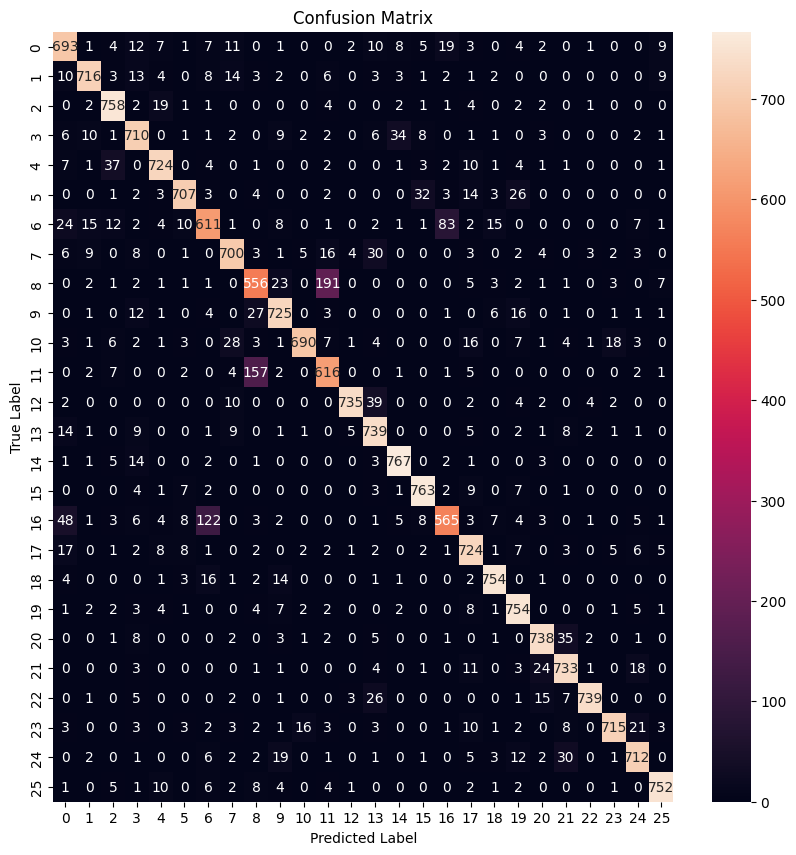

In [26]:
# test on independernt test set
import pickle

with open("best_model.pkl", "rb") as f:
    fnn_model = pickle.load(f)
    
# test on independent test set
test_y_true_list = []
test_y_pred_list = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy().T
    y = one_hot_encode(y.numpy(), 26)

    # Train the FNN model
    input = X
    output = y

    for layer in fnn_model.layers:
        #if dropout layer, skip
        if isinstance(layer, dropout):
            continue
        layer.forward(input)
        input = layer.A

    #compute loss
    AL = fnn_model.layers[-1].A

    #compute accuracy
    predictions = np.argmax(AL, axis=0)
    labels = np.argmax(output, axis=0)

    #populate the lists for confusion matrix
    test_y_true_list.extend(labels)
    test_y_pred_list.extend(predictions)
    
test_y_true_list = np.array(test_y_true_list)
test_y_pred_list = np.array(test_y_pred_list)

test_accuracy = accuracy_score(test_y_true_list, test_y_pred_list)
test_f1_score = f1_score(test_y_true_list, test_y_pred_list, average='macro')

print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Test F1 Score: {:.4f}".format(test_f1_score))

#confusion matrix
cm = confusion_matrix(test_y_true_list, test_y_pred_list)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(f"plots/test_confusion_matrix.png")
plt.show()
